In [1]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold, LeaveOneOut, cross_validate, cross_val_score
)
from sklearn.linear_model import (
    LinearRegression, Lasso, LassoCV, MultiTaskLasso, MultiTaskLassoCV,
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance


# Statistic imports 
from scipy.stats import ks_2samp
from scipy.special import kl_div
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

# Specialized imputation and visualization packages
import miceforest as mf
import missingno as msno
#from missforest import MissForest
#import magic
from src.gain import *

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import xgboost as xgb
import shap

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


In [2]:
df_X_original = pd.read_pickle('../pickle/df_X_original.pickle')
df_X = pd.read_pickle('../pickle/df_X_filtered.pickle')
df_y =  pd.read_pickle('../pickle/df_y_original.pickle')
df_all = pd.read_pickle('../pickle/df_all_original.pickle')
select = pd.read_pickle('../pickle/select_features.pickle')

miss_mask = pd.read_pickle('../pickle/filter_miss_mask.pickle')
miss_mask = miss_mask.tolist()

df_X = df_X_original.drop(columns=[*select["MRIvol"], *select["PET"]])
df_X = df_X[miss_mask]
df_all = df_all[miss_mask]
df_y = df_y[miss_mask]

df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")

results_pickle_folder = "../pickle"

In [3]:
full_palette_graph = {"orange": "#ff4b41", "yellow": "#ffaa41", "blue": "#75d8ff", 
                      "cyan": "#d7d341", "purple":"#e59edd", 
                      "green":"#70d941"}
gender_palette_tab = {
    "0": full_palette_graph["green"], 
    "1": full_palette_graph["purple"]
}
dx_palette_tab = {
    "CN": "#75d8ff",
    "MCI": "#ffcc92",
    "AD": "#ff4b41", 
}

gender_palette = gender_palette_tab
dx_palette = dx_palette_tab
full_palette = full_palette_graph
sns.color_palette(list(full_palette.values()))

[(1.0, 0.29411764705882354, 0.2549019607843137),
 (1.0, 0.6666666666666666, 0.2549019607843137),
 (0.4588235294117647, 0.8470588235294118, 1.0),
 (0.8431372549019608, 0.8274509803921568, 0.2549019607843137),
 (0.8980392156862745, 0.6196078431372549, 0.8666666666666667),
 (0.4392156862745098, 0.8509803921568627, 0.2549019607843137)]

# Train best model

In [4]:
def plot_top_features(feature_importances_list, feature_names, top_n=20, hue=None, palette="viridis"):
    for idx, importances in enumerate(feature_importances_list):
        # Create a DataFrame to pair features with their importances
        feature_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        })

        # Sort by importance and select top N features
        top_features = feature_df.nlargest(top_n, "Importance")

        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=top_features,
            x="Importance",
            y="Feature",
            hue=hue,
            palette=palette
        )
        plt.title(f"Top {top_n} Features for Array {idx + 1}")
        plt.xlabel("Feature Importance")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()

# Step 3: Plotting helper function
def plot_importance(importances, title, top_n=20, hue=None, palette="viridis"):
    """Plot feature importances."""
    importances = importances.head(top_n)
    plt.figure(figsize=(10, 8))
    sns.barplot(
        x="Importance", y="Feature", data=importances, hue=hue, palette=palette, orient="h"
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Mean Permutation Importance (Pearson Correlation)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

# Custom scoring function for Pearson correlation (handles multi-target)
def pearson_scorer(estimator, X, y):
    """Compute Pearson correlation for multi-target predictions."""
    predictions = estimator.predict(X)
    correlations = []
    for i in range(y.shape[1]):  # Iterate over targets
        correlations.append(pearsonr(predictions[:, i], y.iloc[:, i])[0])
    return np.array(correlations)

## Train RandomForestRegressor

In [5]:
if True: 

    idx_train = list(df_X.isna().any(axis=1))
    idx_test = list(~df_X.isna().any(axis=1))

    set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
    intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

    for i, bool_test in enumerate(idx_test): 
        if intersect_rid_idx.iloc[i] & bool_test:
            idx_test[i] = False
            idx_train[i] = True

    df_X_train = df_X.loc[idx_train]
    df_X_test = df_X.loc[idx_test]

    df_y_train = df_y.loc[idx_train]
    df_y_test = df_y.loc[idx_test]

    c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
    c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

    continuous_model  = imputer = KNNImputer(n_neighbors=1)
    name_continuous_imputer  = "KNNImputer"
    ordinal_model = SimpleImputer(strategy="constant", fill_value=-1)
    name_ordinal_imputer = "SimpleImputer_constant"
    rf_model = RandomForestRegressor()
    name_model = "RandomForestRegressor"

    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Separate imputers for ordinal and continuous data
    print("Using separate imputers for ordinal and continuous data.")

    df_X_train = df_X_train.copy()
    df_X_test = df_X_test.copy()

    # Continuous Imputation Transformer (Example: SimpleImputer)
    continuous_imputer = Pipeline([
        (name_continuous_imputer, continuous_model),
    ])

    # Ordinal Imputation Transformer (Example: KNN Imputer)
    ordinal_imputer = Pipeline([
        (name_ordinal_imputer, ordinal_model)
    ])

    # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_imputer, ordinal_features),
            ('continuous', continuous_imputer, continuous_features)
        ],
        remainder='passthrough'
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

        # Separate imputers for ordinal and continuous data

    # Fit and transform, then convert back to DataFrame with original column names
    start = time.time()
    pipeline.fit(df_X_train)
    end = time.time()

    impute_model_time = end - start

    X_train_imputed = pipeline.transform(df_X_train)
    df_X_train_imputed = df_X_train.copy()
    df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

    # Transform the test set
    if df_X_test.isna().any().any(): 
        X_test_imputed = pipeline.transform(df_X_test)
        df_X_test_imputed = df_X_test.copy()
        df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
    else : 
        print("No NaN in test data -> Keep as it is. ")
        df_X_test_imputed = df_X_test

    #df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("category")
    #df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("category")

    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()

    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

    # Perform prediction and save variables
    start = time.time()
    rf_model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = rf_model.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }

    def compute_all_metrics(y_test, y_pred): 
        # Metrics computed in adjusted space
        mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
        mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
        r2 = r2_score(y_test,y_pred, multioutput="raw_values")
        explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

        try: 
            corr_p = correlation(y_pred, y_test)
        except: 
            print("Problem when computing correlation!")
            if type(y_test) != type(y_pred): 
                print("Type of inputs is different.")
                corr_p = None
            else : 
                corr_p = pearsonr(y_test, y_pred)

        return mse_score, mae_score, r2, explained_variance, corr_p

    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted.values)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred.values)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }


Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 


#### Model specific importance

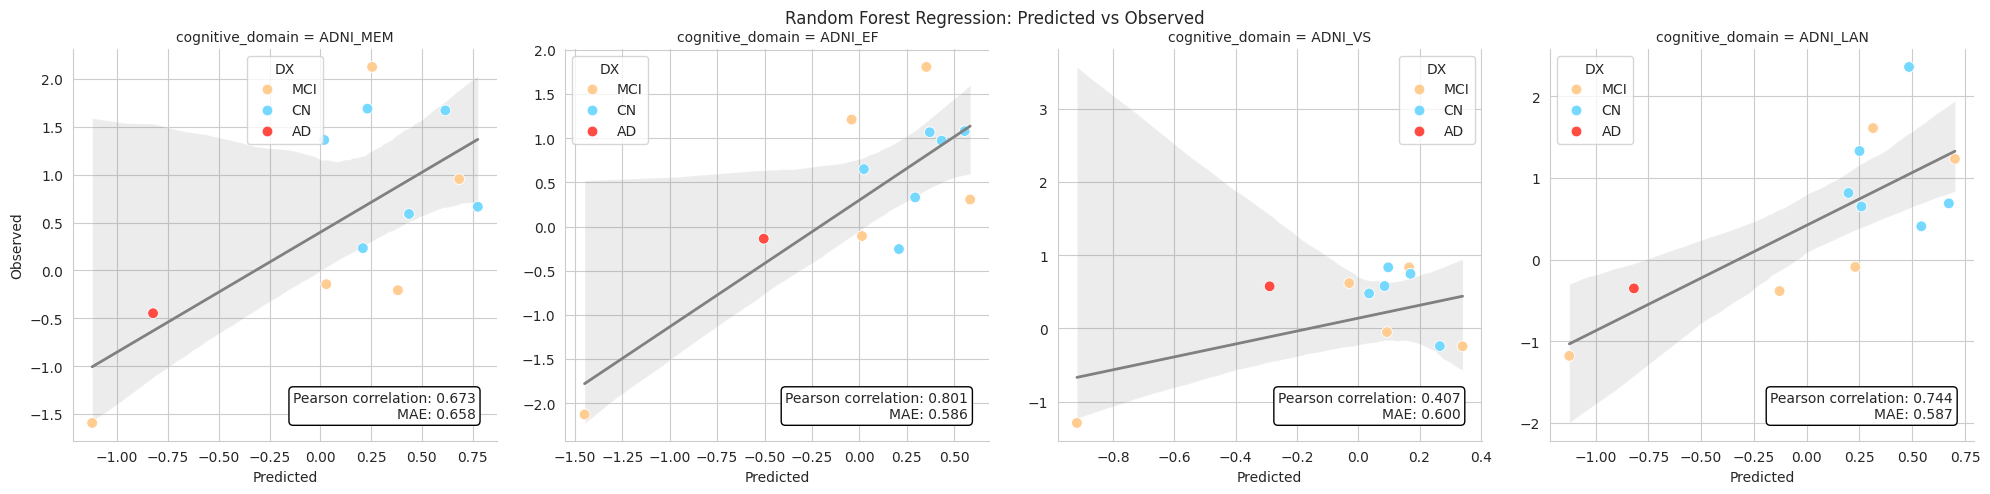

In [6]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

sns.set_style("whitegrid")

# Create the lmplot with only the regression line
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # Remove scatter points
    line_kws={"color": "grey", "lw": 2}  # Customize regression line
)

# Extract the order of cognitive domains from the lmplot
cognitive_domains_order = g.col_names

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=60
    )
    
    # Calculate Pearson correlation and MAE
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])
    
    # Add text annotation in the lower right corner
    ax.text(
        0.95, 0.05,  # Position in axes coordinates
        f"Pearson correlation: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

# Adjust layout and title
g.set_axis_labels("Predicted", "Observed")
g.fig.subplots_adjust(top=0.9)  # Adjust the top for title space
g.fig.suptitle("Random Forest Regression: Predicted vs Observed")  # Add a title

plt.show()


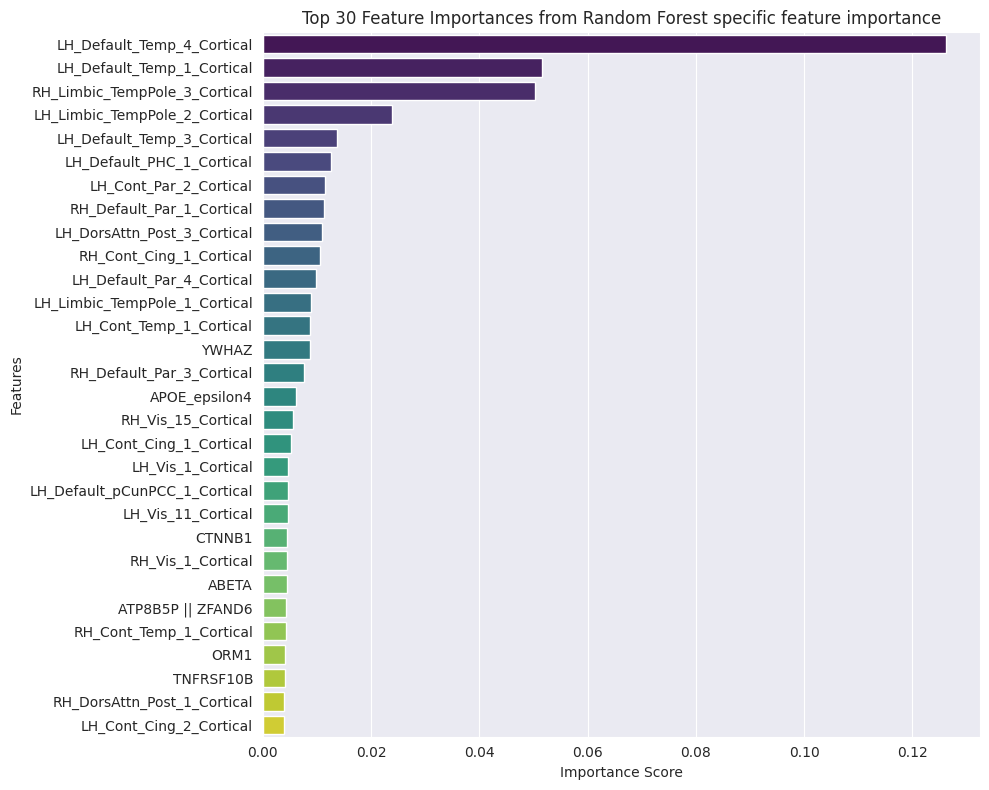

In [7]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

n_features = 30
sns.set_style("darkgrid")

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top 20
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Plot the top 20 feature importances using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(data=top_features_df, x="Importance", y="Feature", palette="viridis")
plt.title(f"Top {n_features} Feature Importances from Random Forest specific feature importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

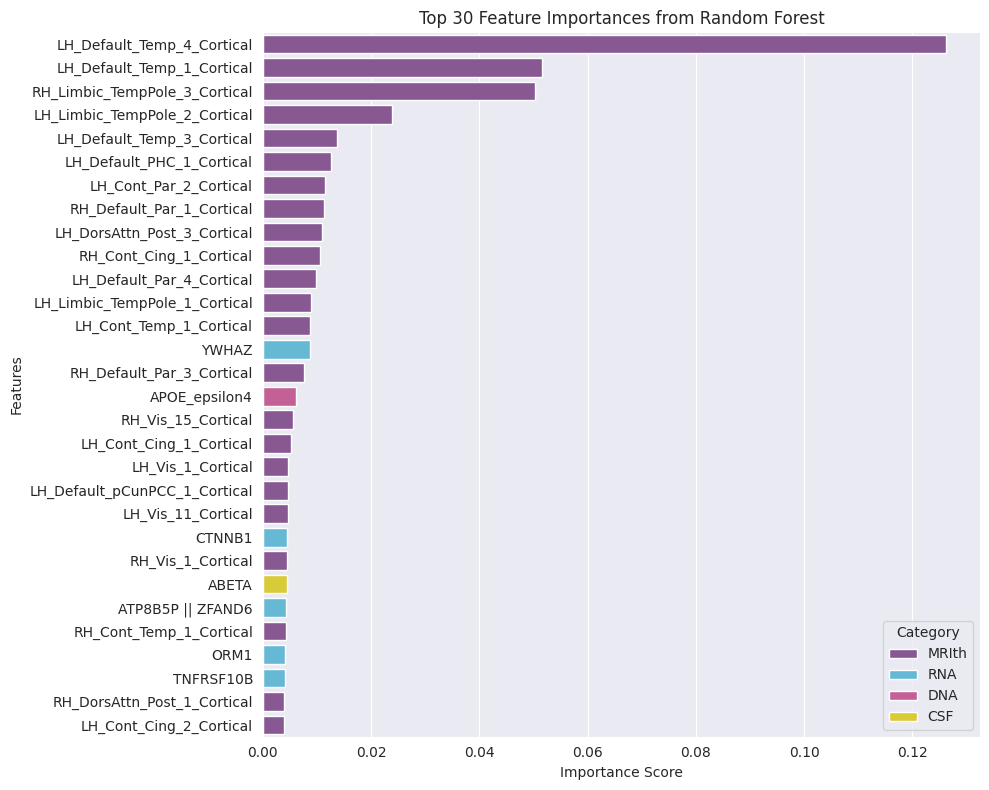

In [8]:

category_palette = {'DNA': '#D35199',
 'RNA': '#52C2E8',
 'CSF': '#F4E01D',
 'MRIth': '#8D4F9A'}

# Extract feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top N features
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Add a 'Category' column based on the 'select' dictionary
top_features_df['Category'] = top_features_df['Feature'].map(
    lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
)

# Plot the barplot with category-based coloring
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_features_df,
    x="Importance",
    y="Feature",
    hue="Category", 
    palette=category_palette
)
plt.title(f"Top {n_features} Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [ ]:
X_test = X_test_adjusted
Y_test = y_test_adjusted
X_train = X_train_adjusted
Y_train = y_train_adjusted

model = rf_model

# Compute permutation importance with Pearson correlation as the scoring metric
result = permutation_importance(
    model, X_test, Y_test, scoring=pearson_scorer, n_repeats=10, random_state=42
)

# Step 1: Extract importance for each target
permutation_results = {}
for i, target in enumerate(Y_test.columns):
    permutation_results[target] = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean[:, i]  # Extract importance for this target
    }).sort_values(by="Importance", ascending=False)

# Step 2: Mean importance across targets
mean_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean.mean(axis=1)  # Mean importance across targets
}).sort_values(by="Importance", ascending=False)


# # Step 4: Plot for each target
# for target in permutation_results:
#     plot_importance(
#         permutation_results[target], title=f"Top 40 Features for Target: {target}"
#     )

# Step 5: Plot for top mean importances across all targets
plot_importance(mean_importance, title=f"Top {n_features} Features by Mean Permutation Importance (Pearson Correlation)", top_n=n_features)


# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = permutation_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h",
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Permutation Importance", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

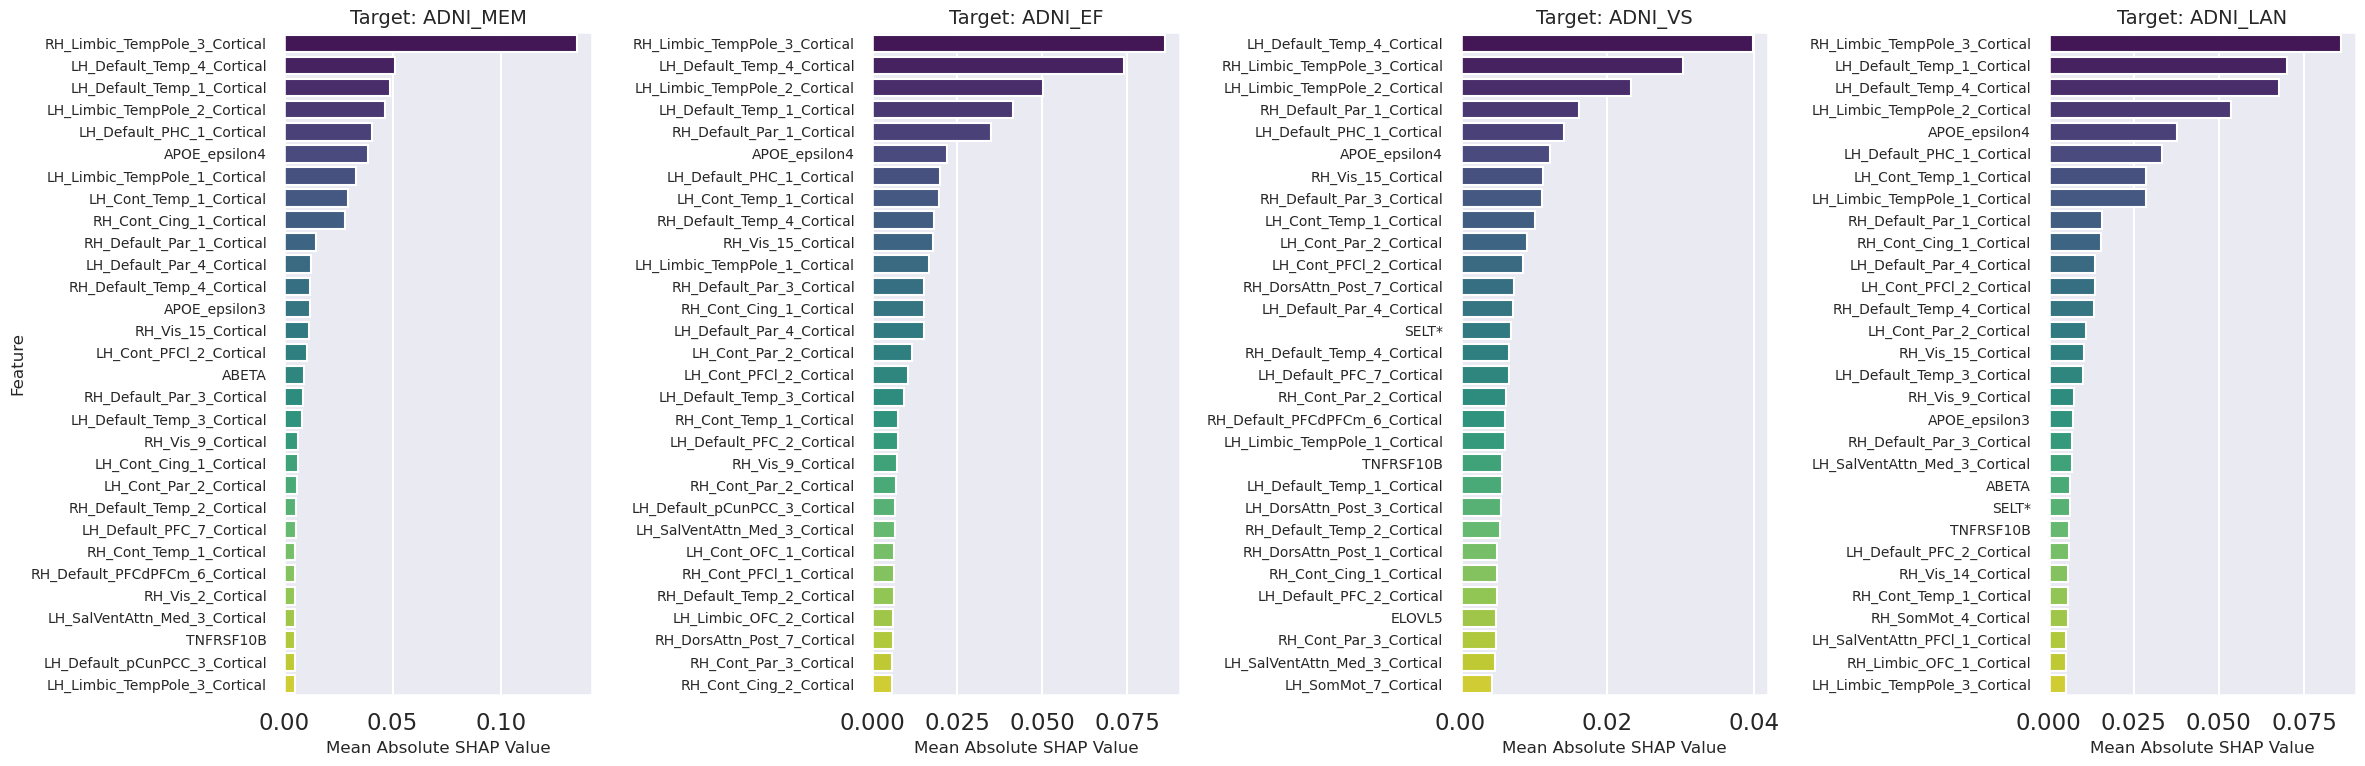

In [ ]:
# Step 1: Compute SHAP values
explainer = shap.KernelExplainer(model.predict, X_test)
shap_values = explainer(X_test)  # This computes SHAP values for all targets

# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

# Step 3: Plot top features for each target as subplots
num_targets = len(Y_test.columns)
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

for i, (target, ax) in enumerate(zip(shap_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = shap_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h"
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Absolute SHAP Value", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


SHAP Summary for Target: ADNI_MEM


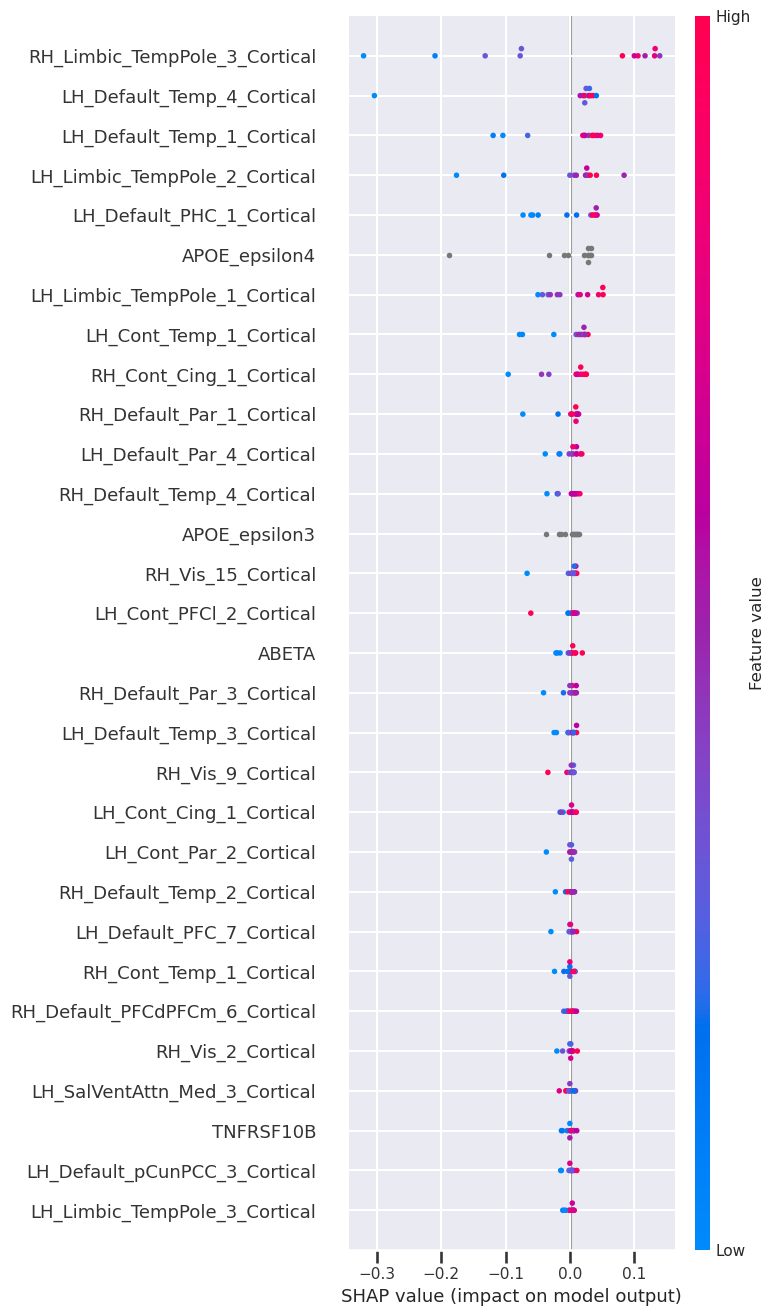

SHAP Summary for Target: ADNI_EF


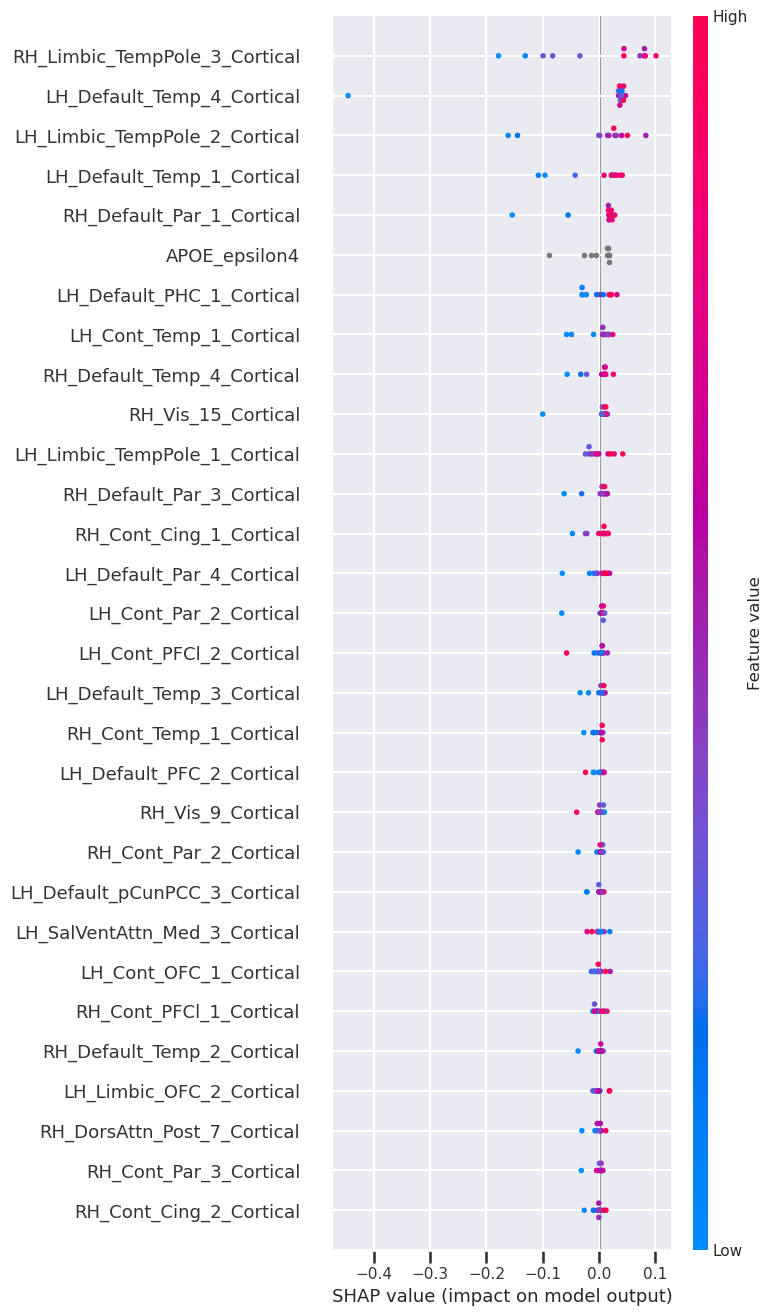

SHAP Summary for Target: ADNI_VS


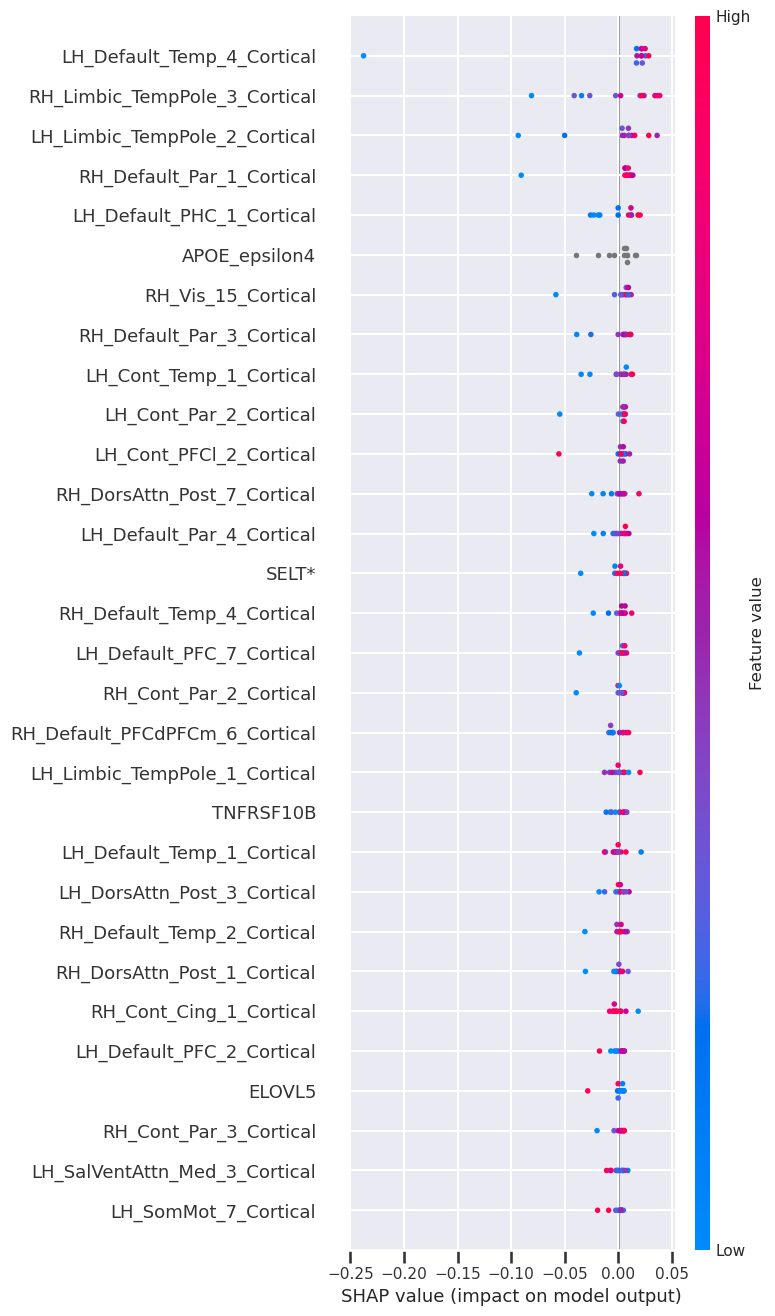

SHAP Summary for Target: ADNI_LAN


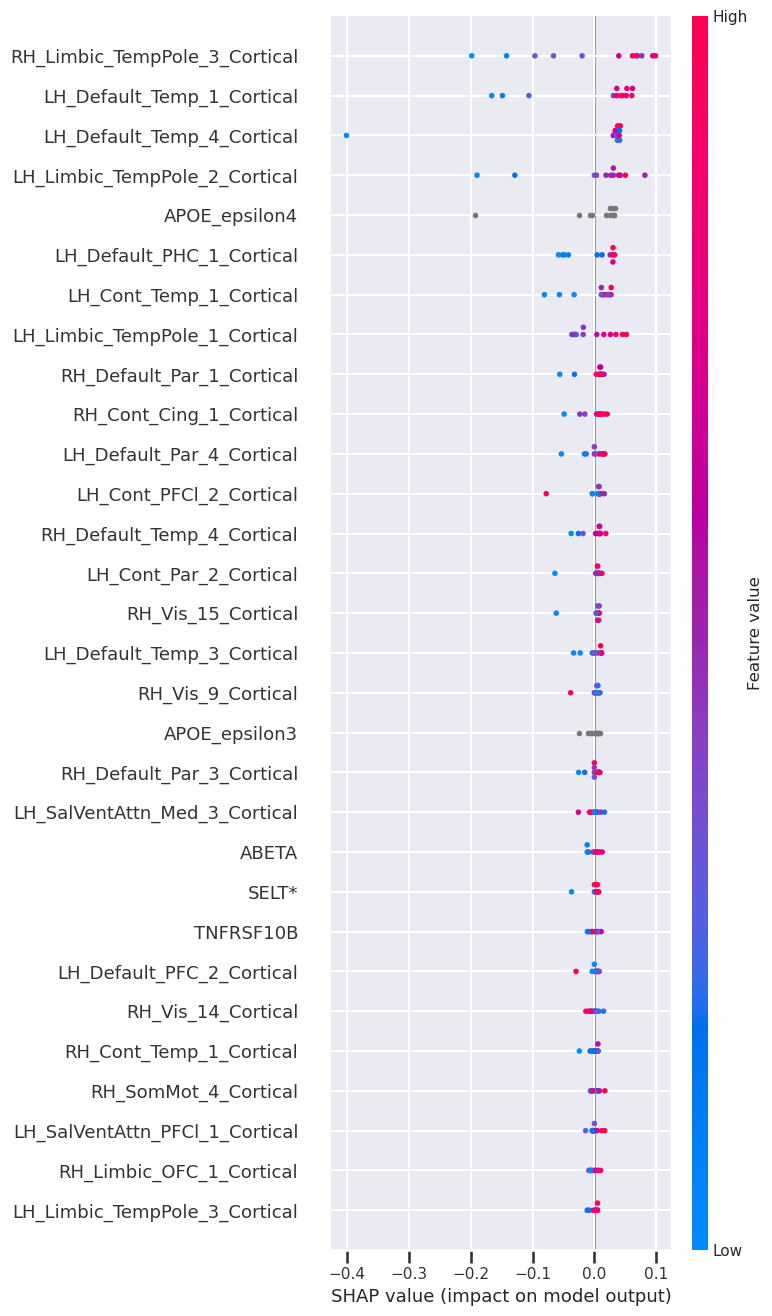

In [ ]:
# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    print(f"SHAP Summary for Target: {target}")
    shap.summary_plot(shap_values.values[:, :, i], X_test, feature_names=X_test.columns, max_display=n_features)

## Train TabNetRegressor

In [ ]:
n_features = 20

In [ ]:
if True: 

    idx_train = list(df_X.isna().any(axis=1))
    idx_test = list(~df_X.isna().any(axis=1))

    set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
    intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

    for i, bool_test in enumerate(idx_test): 
        if intersect_rid_idx.iloc[i] & bool_test:
            idx_test[i] = False
            idx_train[i] = True

    df_X_train = df_X.loc[idx_train]
    df_X_test = df_X.loc[idx_test]

    df_y_train = df_y.loc[idx_train]
    df_y_test = df_y.loc[idx_test]

    c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
    c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

    continuous_model  = imputer = KNNImputer(n_neighbors=1)
    name_continuous_imputer  = "KNNImputer"
    ordinal_model = KNNImputer(n_neighbors=1) #SimpleImputer(strategy="most_frequent", fill_value=-1)
    name_ordinal_imputer = "KNNImputer" #SimpleImputer_constant"
    tabnet_model = TabNetModelWrapper(n_a=8, n_d=8)
    name_model = "TabNetRegressor"

    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Separate imputers for ordinal and continuous data
    print("Using separate imputers for ordinal and continuous data.")

    df_X_train = df_X_train.copy()
    df_X_test = df_X_test.copy()

    # Continuous Imputation Transformer (Example: SimpleImputer)
    continuous_imputer = Pipeline([
        (name_continuous_imputer, continuous_model),
    ])

    # Ordinal Imputation Transformer (Example: KNN Imputer)
    ordinal_imputer = Pipeline([
        (name_ordinal_imputer, ordinal_model)
    ])

    # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_imputer, ordinal_features),
            ('continuous', continuous_imputer, continuous_features)
        ],
        remainder='passthrough'
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

        # Separate imputers for ordinal and continuous data

    # Fit and transform, then convert back to DataFrame with original column names
    start = time.time()
    pipeline.fit(df_X_train)
    end = time.time()

    impute_model_time = end - start

    X_train_imputed = pipeline.transform(df_X_train)
    df_X_train_imputed = df_X_train.copy()
    df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

    # Transform the test set
    if df_X_test.isna().any().any(): 
        X_test_imputed = pipeline.transform(df_X_test)
        df_X_test_imputed = df_X_test.copy()
        df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
    else : 
        print("No NaN in test data -> Keep as it is. ")
        df_X_test_imputed = df_X_test

    #df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("category")
    #df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("category")

    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()

    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

    # Perform prediction and save variables
    start = time.time()
    tabnet_model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = tabnet_model.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }

    def compute_all_metrics(y_test, y_pred): 
        # Metrics computed in adjusted space
        mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
        mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
        r2 = r2_score(y_test,y_pred, multioutput="raw_values")
        explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

        try: 
            corr_p = correlation(y_pred, y_test)
        except: 
            print("Problem when computing correlation!")
            if type(y_test) != type(y_pred): 
                print("Type of inputs is different.")
                corr_p = None
            else : 
                corr_p = pearsonr(y_test, y_pred)

        return mse_score, mae_score, r2, explained_variance, corr_p

    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }


Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
epoch 0  | loss: 2.4785  |  0:00:00s
epoch 1  | loss: 1.58518 |  0:00:00s
epoch 2  | loss: 1.20959 |  0:00:00s
epoch 3  | loss: 1.01853 |  0:00:00s
epoch 4  | loss: 0.9705  |  0:00:00s
epoch 5  | loss: 0.92599 |  0:00:01s
epoch 6  | loss: 0.88482 |  0:00:01s
epoch 7  | loss: 0.86764 |  0:00:01s
epoch 8  | loss: 0.83848 |  0:00:01s
epoch 9  | loss: 0.83755 |  0:00:01s
epoch 10 | loss: 0.81286 |  0:00:01s
epoch 11 | loss: 0.80806 |  0:00:01s
epoch 12 | loss: 0.79248 |  0:00:02s
epoch 13 | loss: 0.77576 |  0:00:02s
epoch 14 | loss: 0.7529  |  0:00:02s
epoch 15 | loss: 0.74626 |  0:00:02s
epoch 16 | loss: 0.73587 |  0:00:02s
epoch 17 | loss: 0.72228 |  0:00:02s
epoch 18 | loss: 0.70576 |  0:00:03s
epoch 19 | loss: 0.69643 |  0:00:03s
epoch 20 | loss: 0.69484 |  0:00:03s
epoch 21 | loss: 0.68705 |  0:00:03s
epoch 22 | loss: 0.67695 |  0:00:03s
epoch 23 | loss: 0.67137 |  0:00:03s
epoch 24 | loss:

In [ ]:
from torchviz import make_dot
import torch

# Create a dummy input with the appropriate shape (e.g., batch_size x num_features)
dummy_input = torch.rand(1, 261)  # Adjust 261 if needed

# Forward pass through your network
y_pred_dummy = tabnet_model.model.network(dummy_input)

# Generate the computation graph visualization using named_parameters()
dot = make_dot(y_pred_dummy, params=dict(tabnet_model.model.network.named_parameters()))
dot.render("../figures/tabnet_network", format="png")

'../figures/tabnet_network.png'

In [ ]:
dummy_input = torch.rand(1, 261)  # Adjust to your model's expected input shape
torch.onnx.export(
    tabnet_model.model.network,
    dummy_input,
    "../figures/tabnet_model.onnx",
    opset_version=11,
    input_names=["input"],
    output_names=["output"]
)

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
tabnet_model.model.network.parameters()

<generator object Module.parameters at 0x753e34d606d0>

In [ ]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment='TabNet Model Summary')

# Define nodes for major components with shapes
dot.node('E', 'Embedder\n(EmbeddingGenerator)', shape='box')
dot.node('T', 'TabNet\n(NoEmbeddings)', shape='box')
dot.node('BN', 'Initial BatchNorm\n(BatchNorm1d)', shape='box')
dot.node('IS', 'Initial Splitter\n(FeatTransformer)', shape='box')
dot.node('GLU_s', 'Shared GLU_Block', shape='box')
dot.node('GLU_sp', 'Specific GLU_Block', shape='box')
dot.node('FT', 'FeatTransformers\n(x3 Blocks)', shape='box')
dot.node('AT', 'AttentiveTransformers\n(x3 Blocks)', shape='box')
dot.node('FM', 'Final Mapping\n(Linear)', shape='box')

# Define edges to show data flow between blocks
dot.edge('E', 'T', label='Embedded Input')
dot.edge('T', 'BN', label='Normalize')
dot.edge('BN', 'IS', label='Pass Normed Data')
dot.edge('IS', 'GLU_s', label='Shared Processing')
dot.edge('IS', 'GLU_sp', label='Specific Processing')
dot.edge('GLU_s', 'FT', label='Merge & Transform')
dot.edge('GLU_sp', 'FT')
dot.edge('FT', 'AT', label='Iterative Feature Refinement')
dot.edge('AT', 'FM', label='Aggregate & Map to Output')

# Render the graph as a PNG file
dot.render('../figures/tabnet_model_summary', format='png', cleanup=True)


'../figures/tabnet_model_summary.png'

In [ ]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

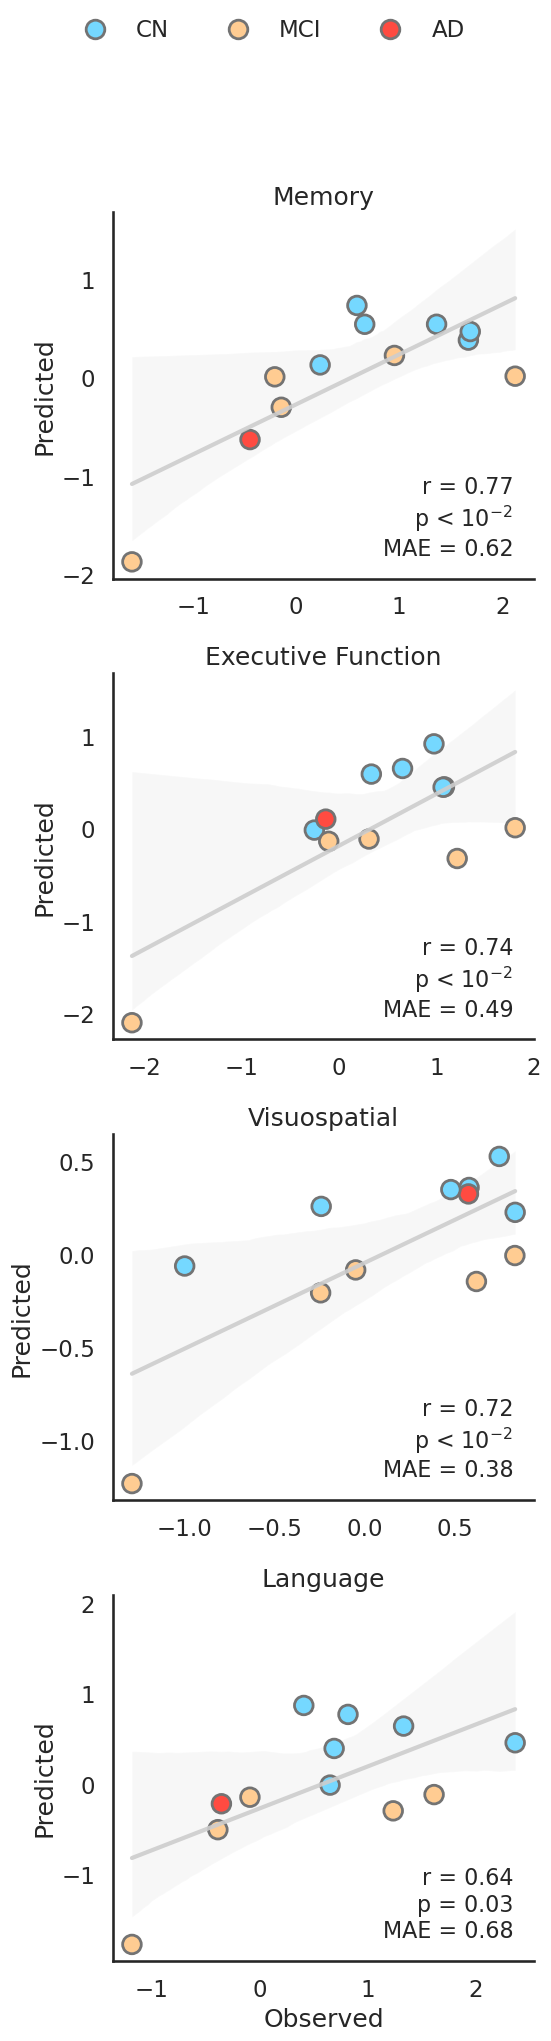

In [ ]:
from scipy.stats import pearsonr

# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Cognitive domain name replacements
domain_replacements = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
}

# Replace cognitive domain names
merged_df["cognitive_domain"] = merged_df["cognitive_domain"].replace(domain_replacements)

# Create lmplot with only regression line and 2x2 layout
g = sns.lmplot(
    data=merged_df,
    x="y_test",  # Observed values
    y="y_pred",  # Predicted values
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    aspect=1.2,
    scatter=False,  # Remove scatter points
    line_kws={"color": "#CDCDCD", "lw": 3, "alpha": 0.9},
    col_wrap=1  # Arrange as 2x2
)

# Extract the cognitive domains order
cognitive_domains_order = g.col_names

# Initialize a variable to collect legend handles
legend_handles = None

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    scatter = sns.scatterplot(
        data=group_data,
        x="y_test",
        y="y_pred",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=180,
        edgecolor="#737373",
        linewidth=2
    )
    
    # Save legend handles from the first scatterplot
    if legend_handles is None:
        legend_handles, legend_labels = scatter.get_legend_handles_labels()
    
    scatter.get_legend().remove()
    
    # Calculate Pearson correlation, p-value, and MAE
    correlation, p_value = pearsonr(group_data["y_test"], group_data["y_pred"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])

    # Add text annotation with formatted Pearson correlation, p-value, and MAE
    p_text = f"p < $10^{{-2}}$" if p_value < 0.01 else f"p = {p_value:.2f}"
    ax.text(
        0.95, 0.05,
        f"r = {correlation:.2f}\n{p_text}\nMAE = {mae:.2f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=16  # Increased font size
    )
    
    # Set the title to the simplified cognitive domain name
    ax.set_title(cognitive_domain)

# Set axis labels and adjust layout
g.set_axis_labels("Observed", "Predicted")

order = [1, 0, 2]
legend_handles = [legend_handles[i] for i in order]
legend_labels = [legend_labels[i] for i in order]

# Add a single legend for all plots
plt.figlegend(
    handles=legend_handles, labels=legend_labels,  # Exclude 'DX' label
    title="",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.03),
    ncol=3,  # Arrange legend items in a horizontal row
    frameon=False  # Remove the legend box
)

# Adjust layout for spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for legend at the top

# Show the plot
plt.savefig("../figures/tabnet_correlation_target.png", bbox_inches='tight', format="png")

#### Model specific importance values

In [ ]:
full_palette_graph

{'orange': '#ff4b41',
 'yellow': '#ffaa41',
 'blue': '#75d8ff',
 'cyan': '#d7d341',
 'purple': '#e59edd',
 'green': '#70d941'}

In [ ]:
cat_palette = {'RNA': full_palette_graph["yellow"],
 'MRIth': full_palette_graph["cyan"],
 'CSF': full_palette_graph["blue"],
 'DNA': full_palette_graph["orange"],
 'ADNI_cog': full_palette_graph["green"]
 }

category_palette = {'RNA':full_palette_graph["yellow"],
 'MRIth': full_palette_graph["cyan"],
 'CSF': full_palette_graph["blue"],
 'DNA': full_palette_graph["orange"]}

sns.color_palette(category_palette.values())

[(1.0, 0.6666666666666666, 0.2549019607843137),
 (0.8431372549019608, 0.8274509803921568, 0.2549019607843137),
 (0.4588235294117647, 0.8470588235294118, 1.0),
 (1.0, 0.29411764705882354, 0.2549019607843137)]

In [ ]:
# Function to clean up y-tick labels
def clean_ytick_label(label):
    label = label.replace("_epsilon", "").replace("_Cortical", "")
    label = label.replace("LH", "Left").replace("RH", "Right")
    label = label.replace("LH", "Left").replace("RH", "Right")
    label = label.replace("LH", "Left").replace("RH", "Right")
    label = label.replace("_", " ")  # Remove remaining underscores
    if len(label.split(" || ")) > 1: 
        label = label.split(" || ")[1]
    
    return label

In [ ]:
n_features = 20

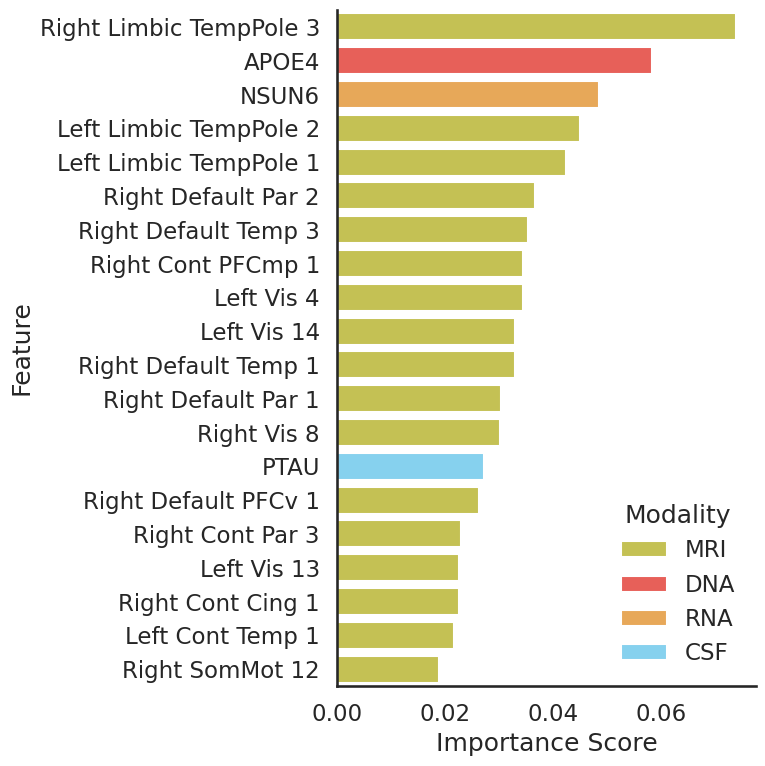

In [ ]:
# Extract feature importances
feature_importances = tabnet_model.model.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top N features
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Add a 'Category' column based on the 'select' dictionary
top_features_df['Modality'] = top_features_df['Feature'].map(
    lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
)

sns.set_style("white")
sns.set_context("talk")
#sns.set(font="Helvetica")

# Plot the barplot with category-based coloring
plt.figure(figsize=(8, 8))

ax = sns.barplot(
    data=top_features_df,
    x="Importance",
    y="Feature",
    hue="Modality", 
    palette=category_palette
)
plt.xlabel("Importance Score")
plt.ylabel("Feature")

# Apply changes to y-tick labels for each subplot
#for ax in g.axes.flat:
# Get current y-tick labels
ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]

# Update y-tick labels
new_labels = [clean_ytick_label(label) for label in ytick_labels]
ax.set_yticklabels(new_labels)

# Get current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Replace "MRIth" with "MRI" in the labels
updated_labels = [label.replace("MRIth", "MRI") for label in labels]

# Set the updated legend
ax.legend(handles, updated_labels, title="Modality", loc="best", frameon=False)

sns.despine()

plt.tight_layout()
plt.show()


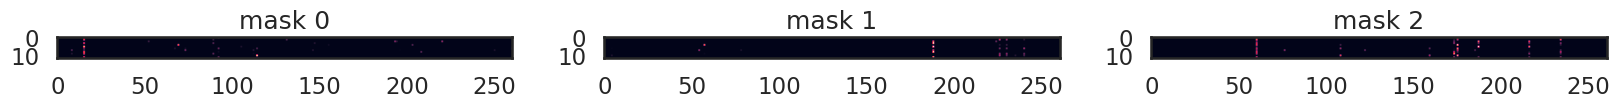

In [ ]:
explain_matrix, masks = tabnet_model.model.explain(X_test_adjusted.values)

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

<Figure size 640x480 with 0 Axes>

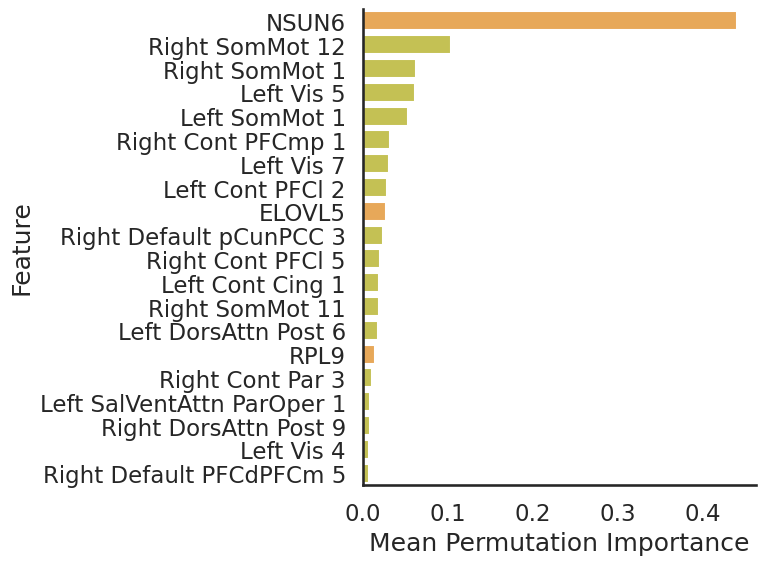

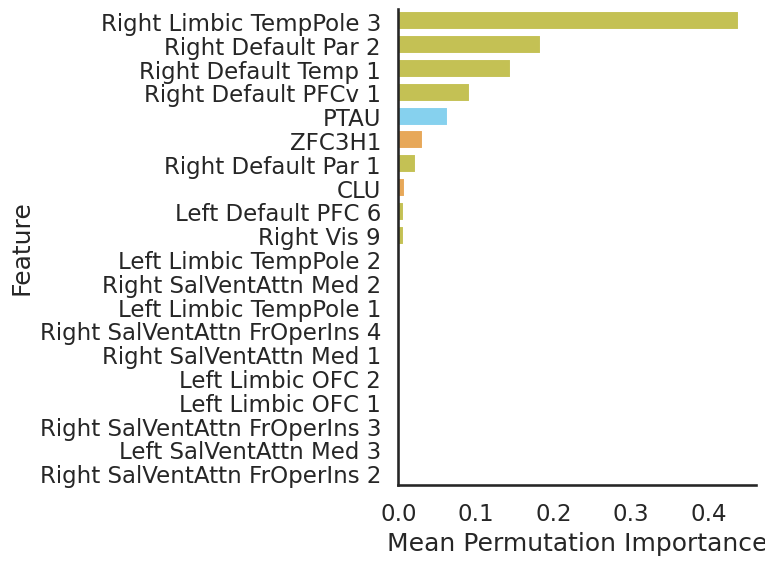

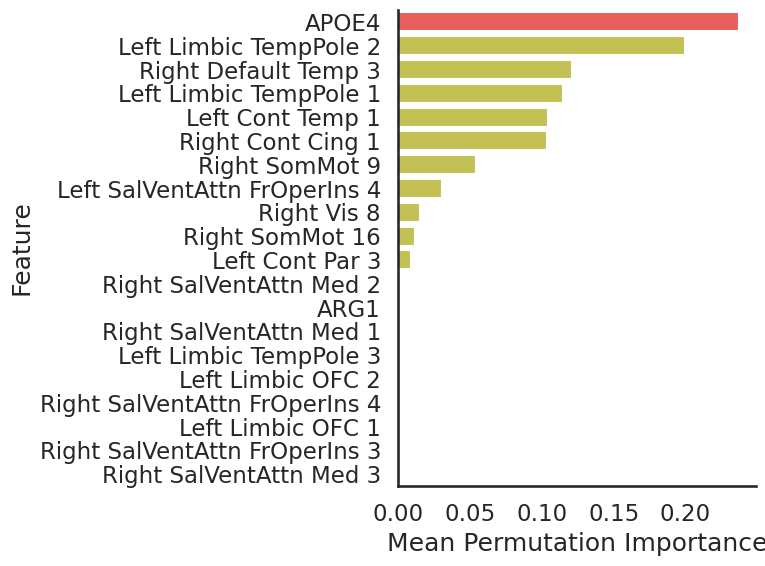

In [ ]:
for item in masks.values(): 

    sns.despine()
    plt.tight_layout()
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    
    # Select the top n features for the current target
    importances = pd.DataFrame({"Feature": df_X.columns.tolist(), "Importance": item.mean(0)})
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
    )

    importances.sort_values("Importance", ascending=False)
    
    # Create the barplot
    ax = sns.barplot(
        x="Importance", y="Feature", data=importances.sort_values("Importance", ascending=False).head(20),
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)

    ax.set_xlabel("Mean Permutation Importance", fontsize=18)
    ax.set_ylabel("Feature", fontsize=18)
    
    # Remove legend from each individual plot
    ax.legend().set_visible(False)
    
    sns.despine()
    plt.tight_layout()


#### Permutation importance values

In [ ]:
from sklearn.metrics import mean_absolute_error, make_scorer

# Create a scorer from mean_absolute_error
mae_scorer = make_scorer(mean_absolute_error, multioutput="raw_values", greater_is_better=False)

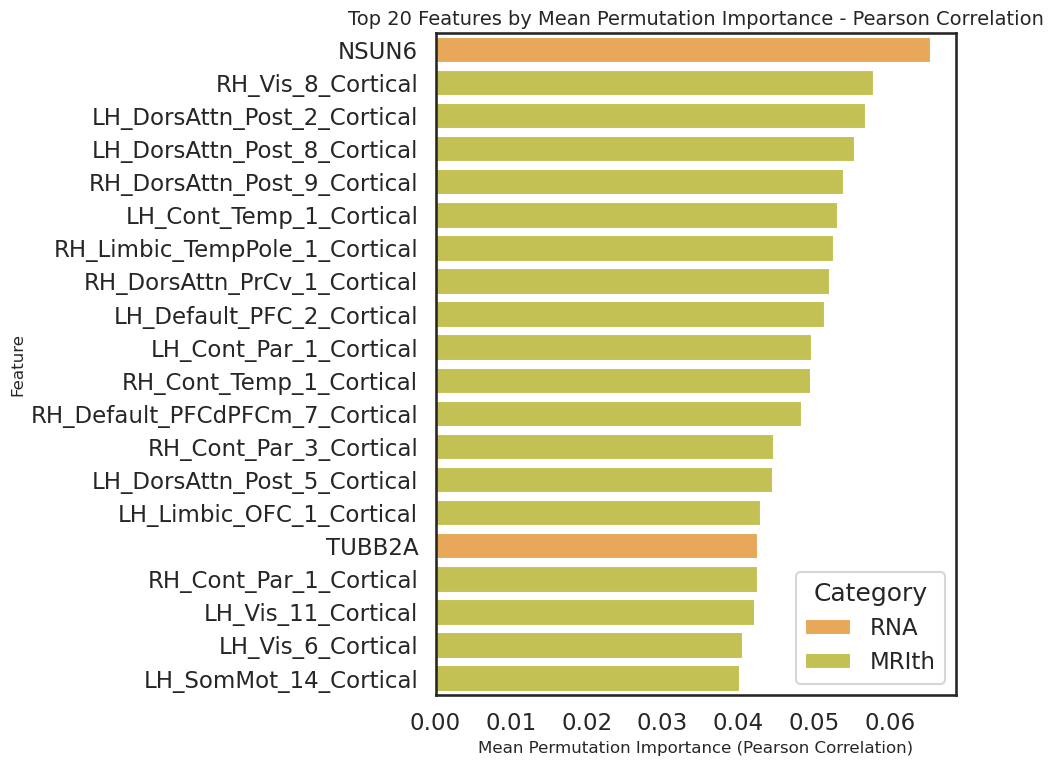

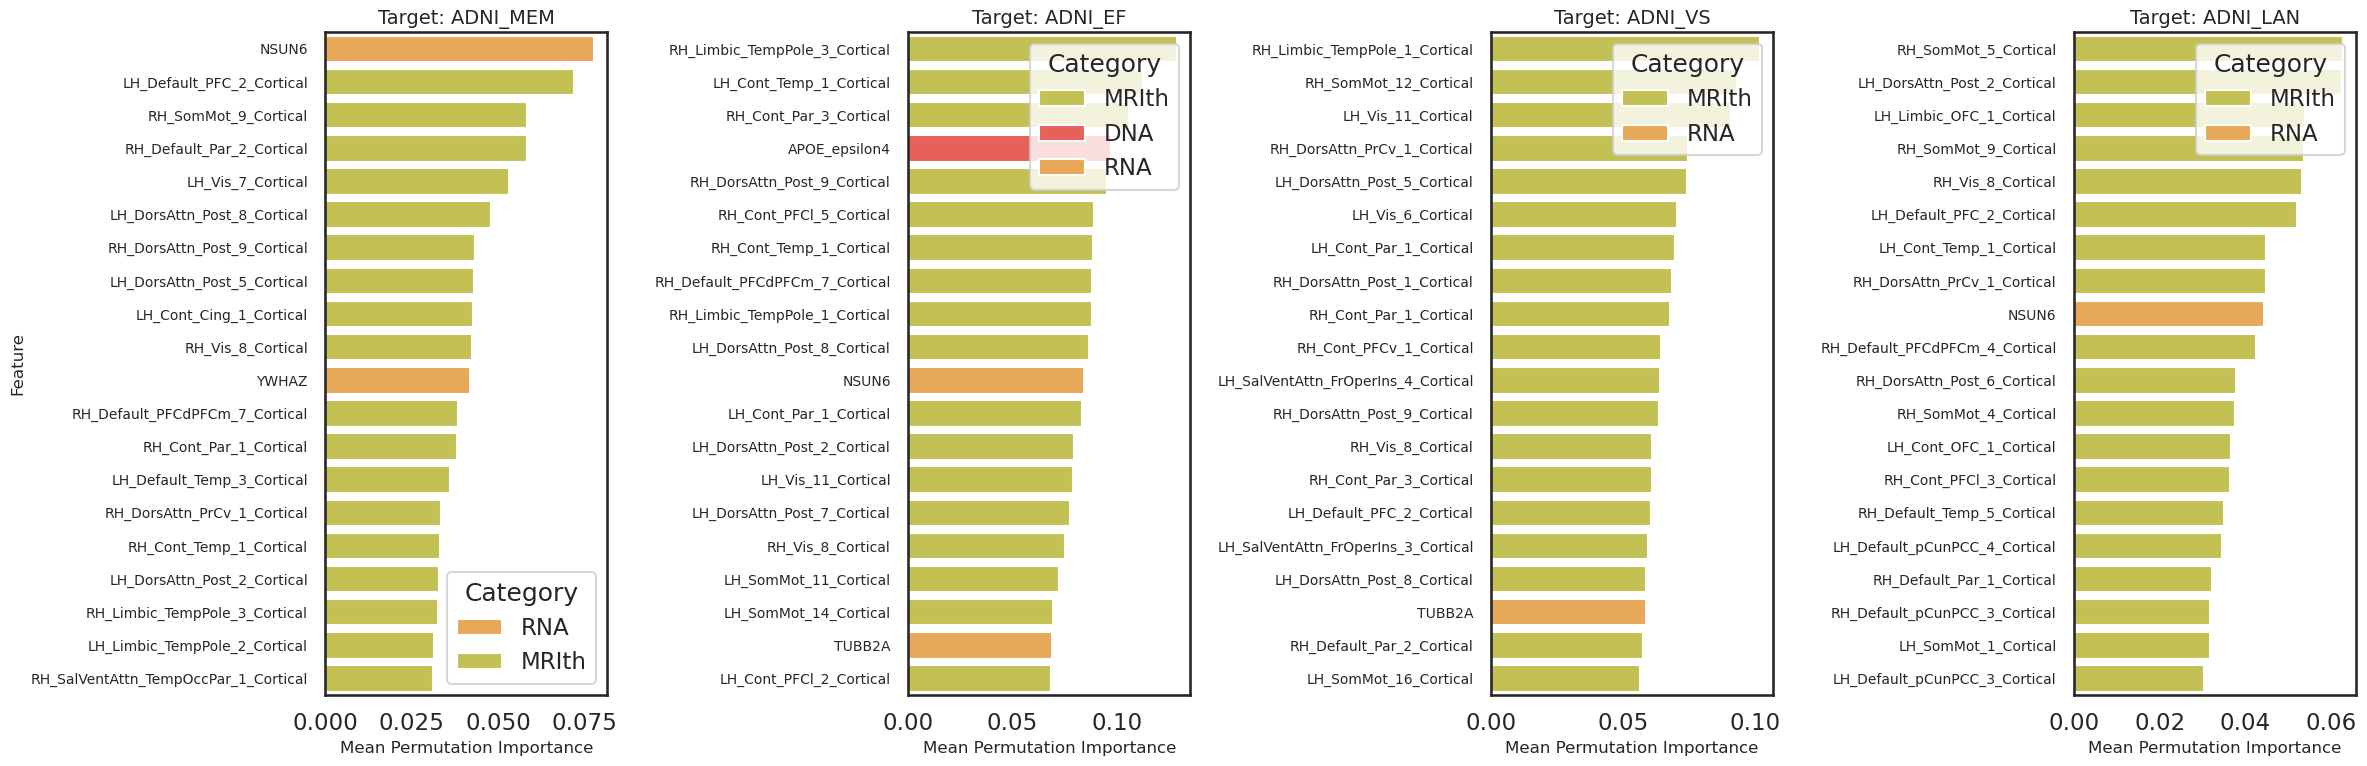

In [ ]:
X_test = X_test_adjusted
X_train = X_train_adjusted
Y_test = y_test_adjusted

model = tabnet_model

# Compute permutation importance with Pearson correlation as the scoring metric
result = permutation_importance(
    model, X_test, Y_test, scoring=mae_scorer, n_repeats=10, random_state=42
)

# Step 1: Extract importance for each target
permutation_results = {}
for i, target in enumerate(Y_test.columns):
    permutation_results[target] = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean[:, i]  # Extract importance for this target
    }).sort_values(by="Importance", ascending=False)

# Step 2: Mean importance across targets
mean_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean.mean(axis=1)  # Mean importance across targets
}).sort_values(by="Importance", ascending=False)

# Add a 'Category' column based on the 'select' dictionary
mean_importance['Category'] = mean_importance['Feature'].map(
    lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
)

# # Step 4: Plot for each target
# for target in permutation_results:
#     plot_importance(
#         permutation_results[target], title=f"Top 40 Features for Target: {target}"
#     )

# Step 5: Plot for top mean importances across all targets
plot_importance(mean_importance, title=f"Top {n_features} Features by Mean Permutation Importance - Pearson Correlation", top_n=n_features, hue="Category", palette=category_palette)

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = permutation_results[target].head(n_features)

    importances['Category'] = importances['Feature'].map(
    lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette=category_palette, hue="Category", orient="h",
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Permutation Importance", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

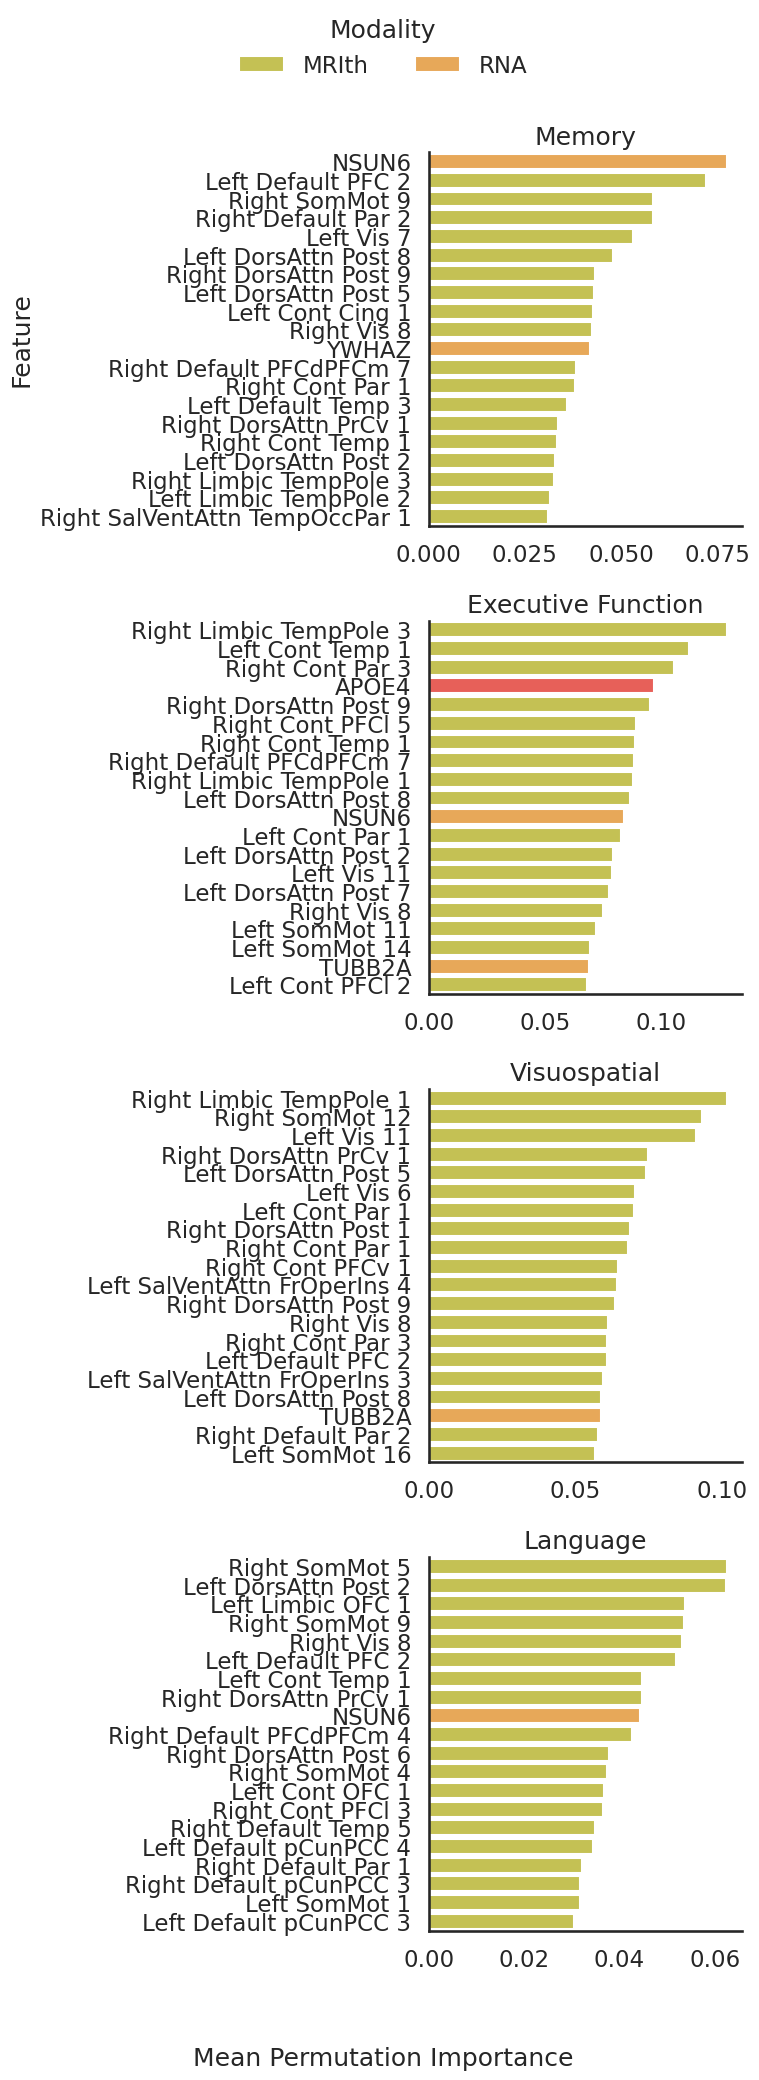

In [ ]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(num_targets, 1, figsize=(8, 5 * num_targets), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top n features for the current target
    importances = permutation_results[target].head(n_features)
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
    )
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax,
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)
    
    # Title and labels
    readable_title = readable_names.get(target, target)  # Use readable name or fallback to original
    ax.set_title(readable_title, fontsize=18)
    
    ax.set_xlabel("")  # Remove individual x-labels
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature")
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y')

    ax.legend().set_visible(False)

# Remove duplicate legends and create a single, consistent legend
handles, labels = axes[0].get_legend_handles_labels()
unique_handles_labels = list(zip(handles, labels))
handles, labels = zip(*sorted(unique_handles_labels, key=lambda x: x[1]))  # Sort legend alphabetically

fig.legend(
    handles, labels, title="Modality", loc="upper center", bbox_to_anchor=(0.5, 1.05),
    ncol=3, frameon=False
)

# Add a single x-label in the bottom-middle of the figure
fig.text(0.5, 0.02, "Mean Permutation Importance", ha="center", va="center", fontsize=18)

sns.despine()

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the x-label
plt.show()


<Figure size 640x480 with 0 Axes>

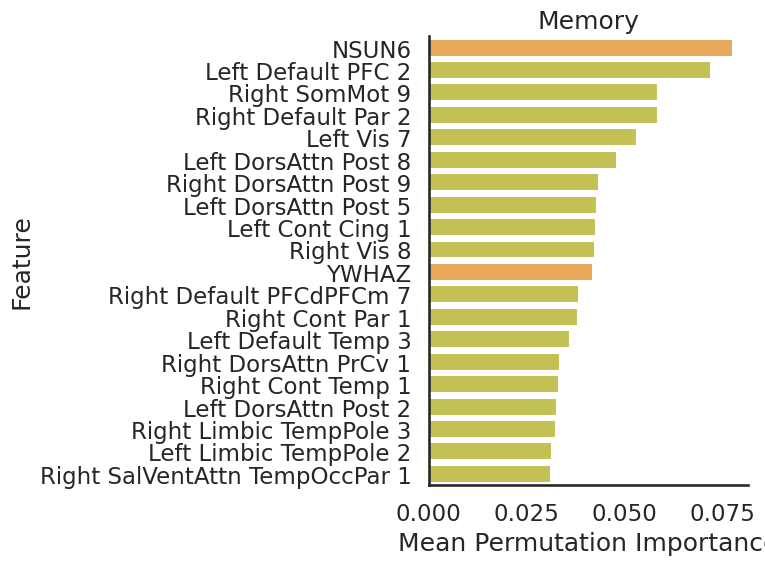

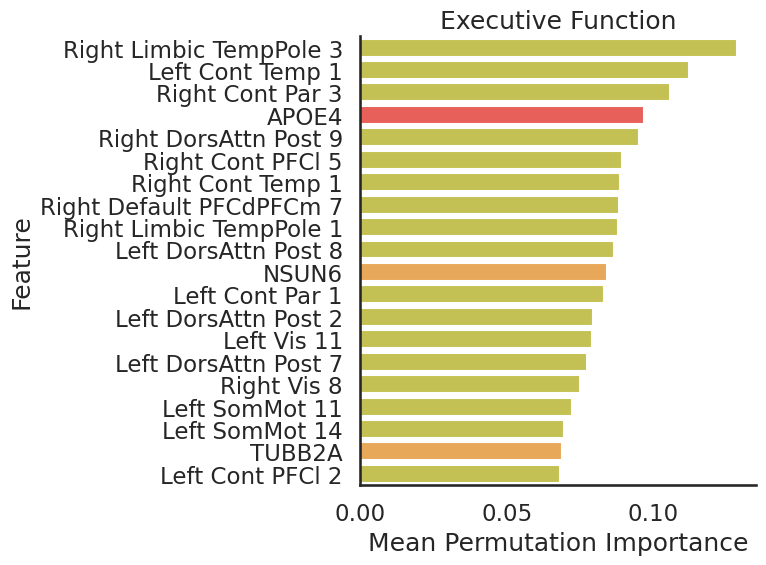

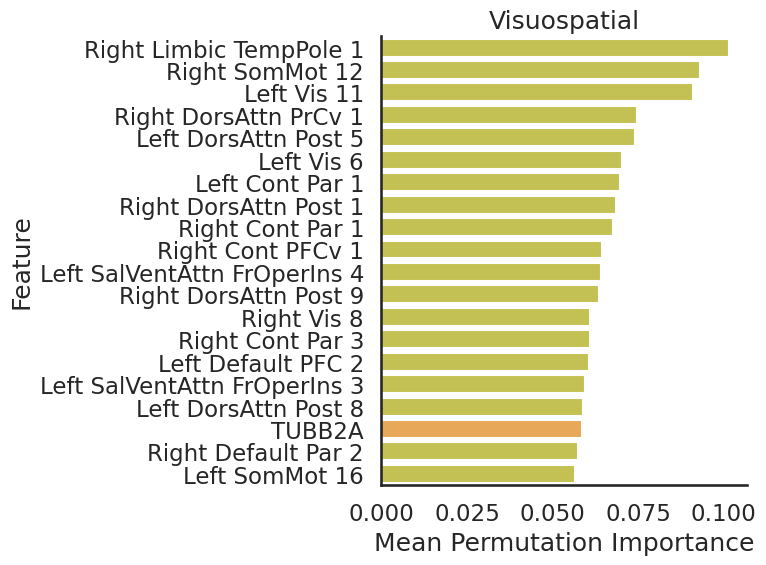

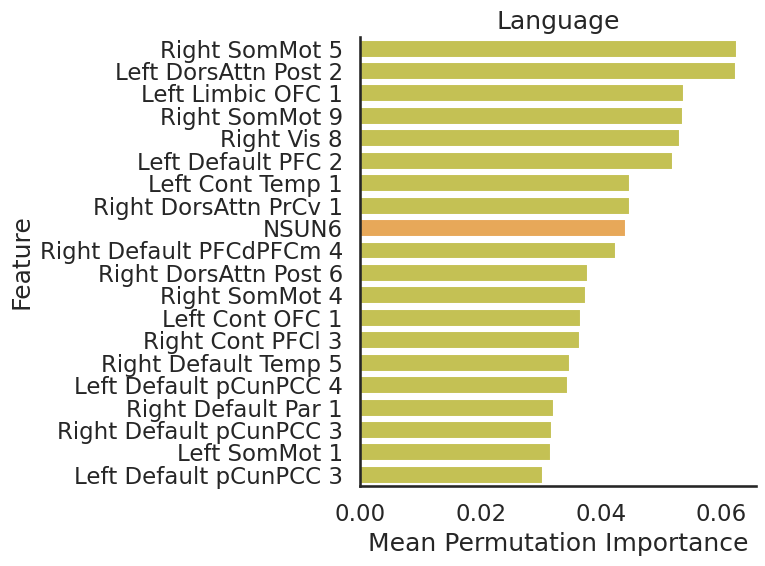

In [ ]:
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
}

# Generate individual plots for each target
for target in permutation_results.keys():

    sns.despine()
    plt.tight_layout()
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    
    # Select the top n features for the current target
    importances = permutation_results[target].head(n_features)
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
    )
    
    # Create the barplot
    ax = sns.barplot(
        x="Importance", y="Feature", data=importances,
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)
    
    # Title and labels
    readable_title = readable_names.get(target, target)
    ax.set_title(readable_title, fontsize=18)
    
    ax.set_xlabel("Mean Permutation Importance", fontsize=18)
    ax.set_ylabel("Feature", fontsize=18)
    
    # Remove legend from each individual plot
    ax.legend().set_visible(False)
    
    sns.despine()
    plt.tight_layout()

    plt.savefig(f"../figures/tabnet_perm_mae_{readable_title}.png", bbox_inches="tight")


### Permutation importance on subset of X_train

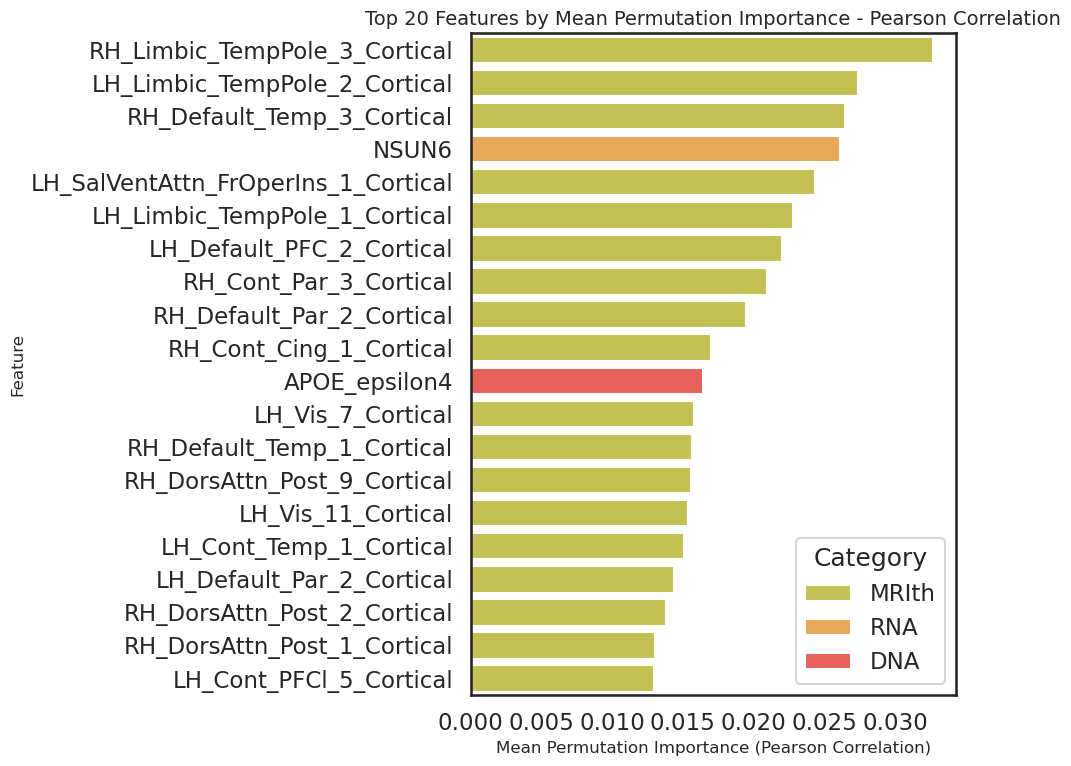

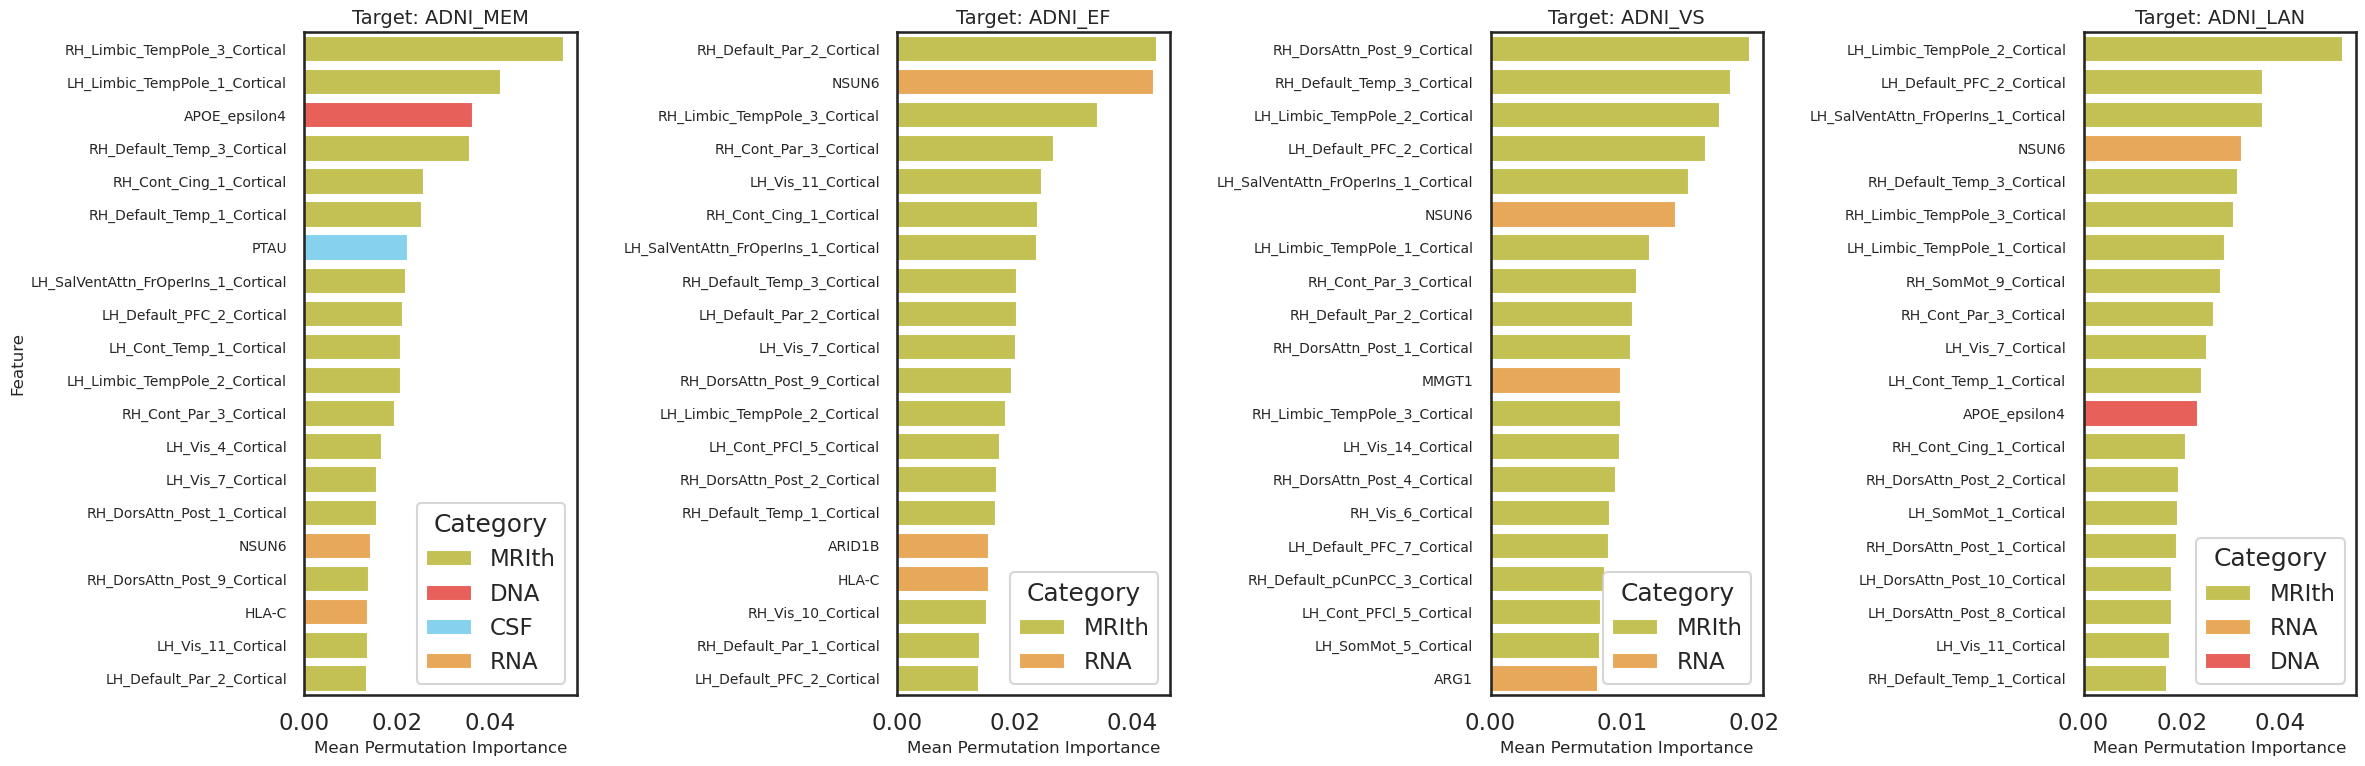

In [ ]:
random_idx = random.sample(X_train_adjusted.index.tolist(), k=200)

X_test = X_train_adjusted.loc[random_idx]
Y_test = y_train_adjusted.loc[random_idx]

model = tabnet_model

# Compute permutation importance with Pearson correlation as the scoring metric
result = permutation_importance(
    model, X_test, Y_test, scoring=mae_scorer, n_repeats=10, random_state=42
)

# Step 1: Extract importance for each target
permutation_results = {}
for i, target in enumerate(Y_test.columns):
    permutation_results[target] = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean[:, i]  # Extract importance for this target
    }).sort_values(by="Importance", ascending=False)

# Step 2: Mean importance across targets
mean_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean.mean(axis=1)  # Mean importance across targets
}).sort_values(by="Importance", ascending=False)

# Add a 'Category' column based on the 'select' dictionary
mean_importance['Category'] = mean_importance['Feature'].map(
    lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
)

# Step 5: Plot for top mean importances across all targets
plot_importance(mean_importance, title=f"Top {n_features} Features by Mean Permutation Importance - Pearson Correlation", top_n=n_features, hue="Category", palette=category_palette)

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = permutation_results[target].head(n_features)

    importances['Category'] = importances['Feature'].map(
    lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette=category_palette, hue="Category", orient="h",
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Permutation Importance", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

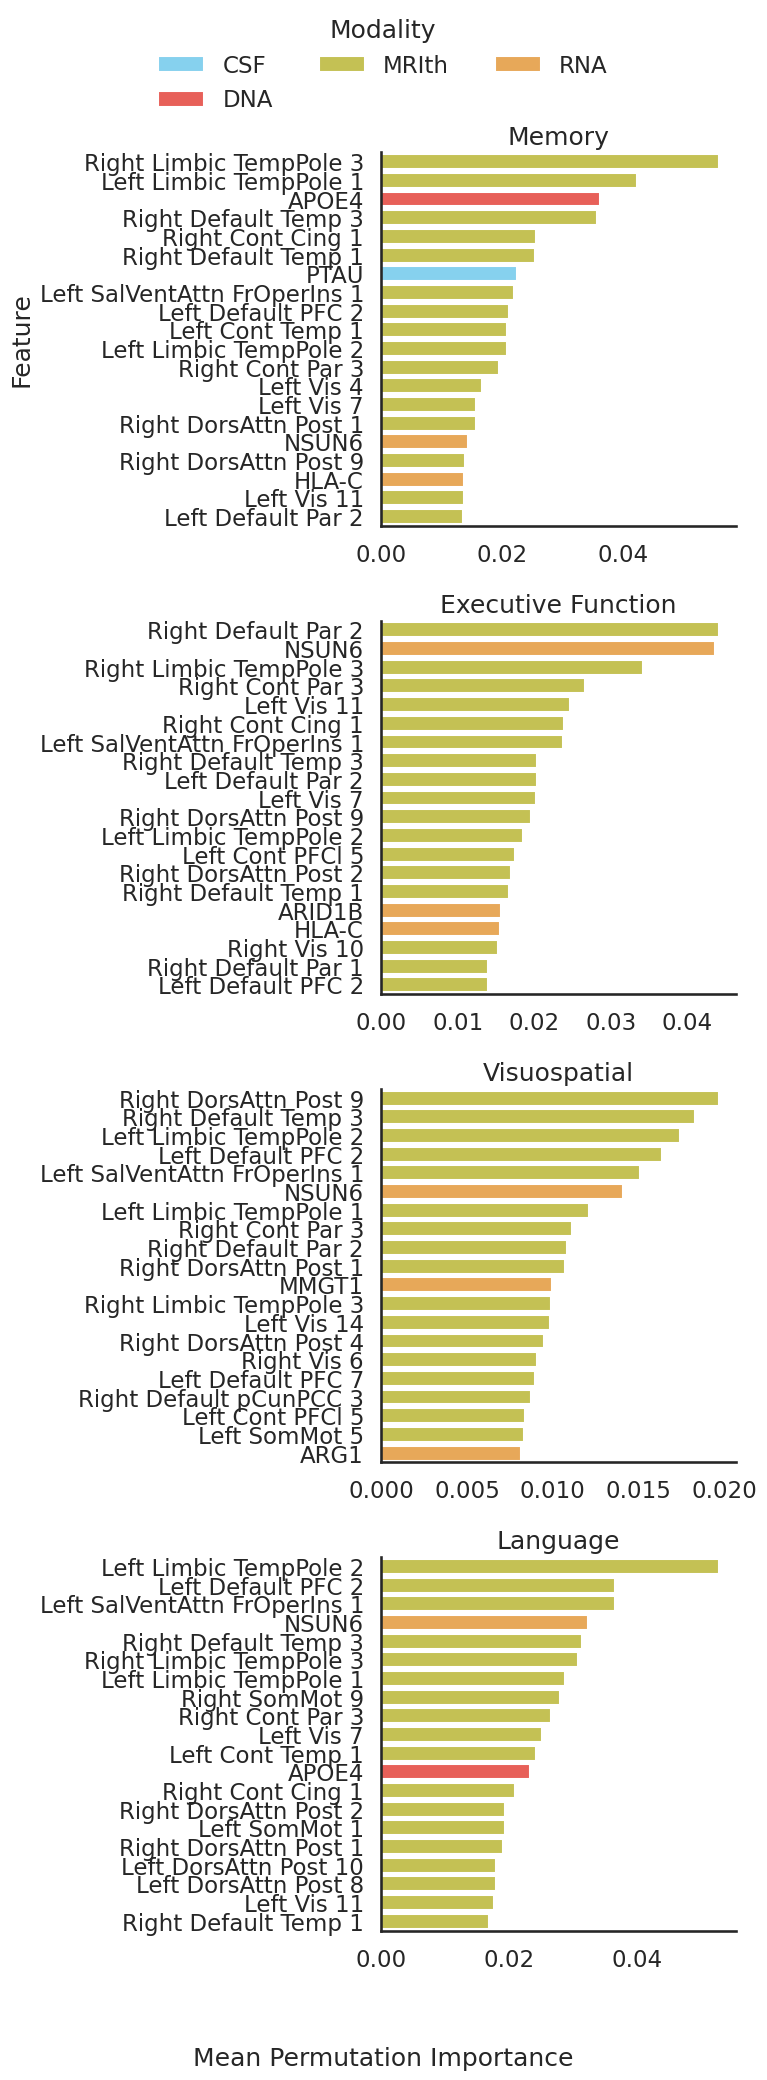

In [ ]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(num_targets, 1, figsize=(8, 5 * num_targets), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top n features for the current target
    importances = permutation_results[target].head(n_features)
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
    )
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax,
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)
    
    # Title and labels
    readable_title = readable_names.get(target, target)  # Use readable name or fallback to original
    ax.set_title(readable_title, fontsize=18)
    
    ax.set_xlabel("")  # Remove individual x-labels
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature")
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y')

    ax.legend().set_visible(False)

# Remove duplicate legends and create a single, consistent legend
handles, labels = axes[0].get_legend_handles_labels()
unique_handles_labels = list(zip(handles, labels))
handles, labels = zip(*sorted(unique_handles_labels, key=lambda x: x[1]))  # Sort legend alphabetically

fig.legend(
    handles, labels, title="Modality", loc="upper center", bbox_to_anchor=(0.5, 1.05),
    ncol=3, frameon=False
)

# Add a single x-label in the bottom-middle of the figure
fig.text(0.5, 0.02, "Mean Permutation Importance", ha="center", va="center", fontsize=18)

sns.despine()

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the x-label
plt.show()


#### Shapeley values

In [ ]:
X_test = X_test_adjusted
Y_test = y_test_adjusted

# Step 1: Initialize the SHAP Explainer and Compute SHAP Values
explainer = shap.KernelExplainer(model.model.predict, X_test)
shap_values = explainer(X_test)  # SHAP values for all targets

# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

  0%|          | 0/12 [00:00<?, ?it/s]

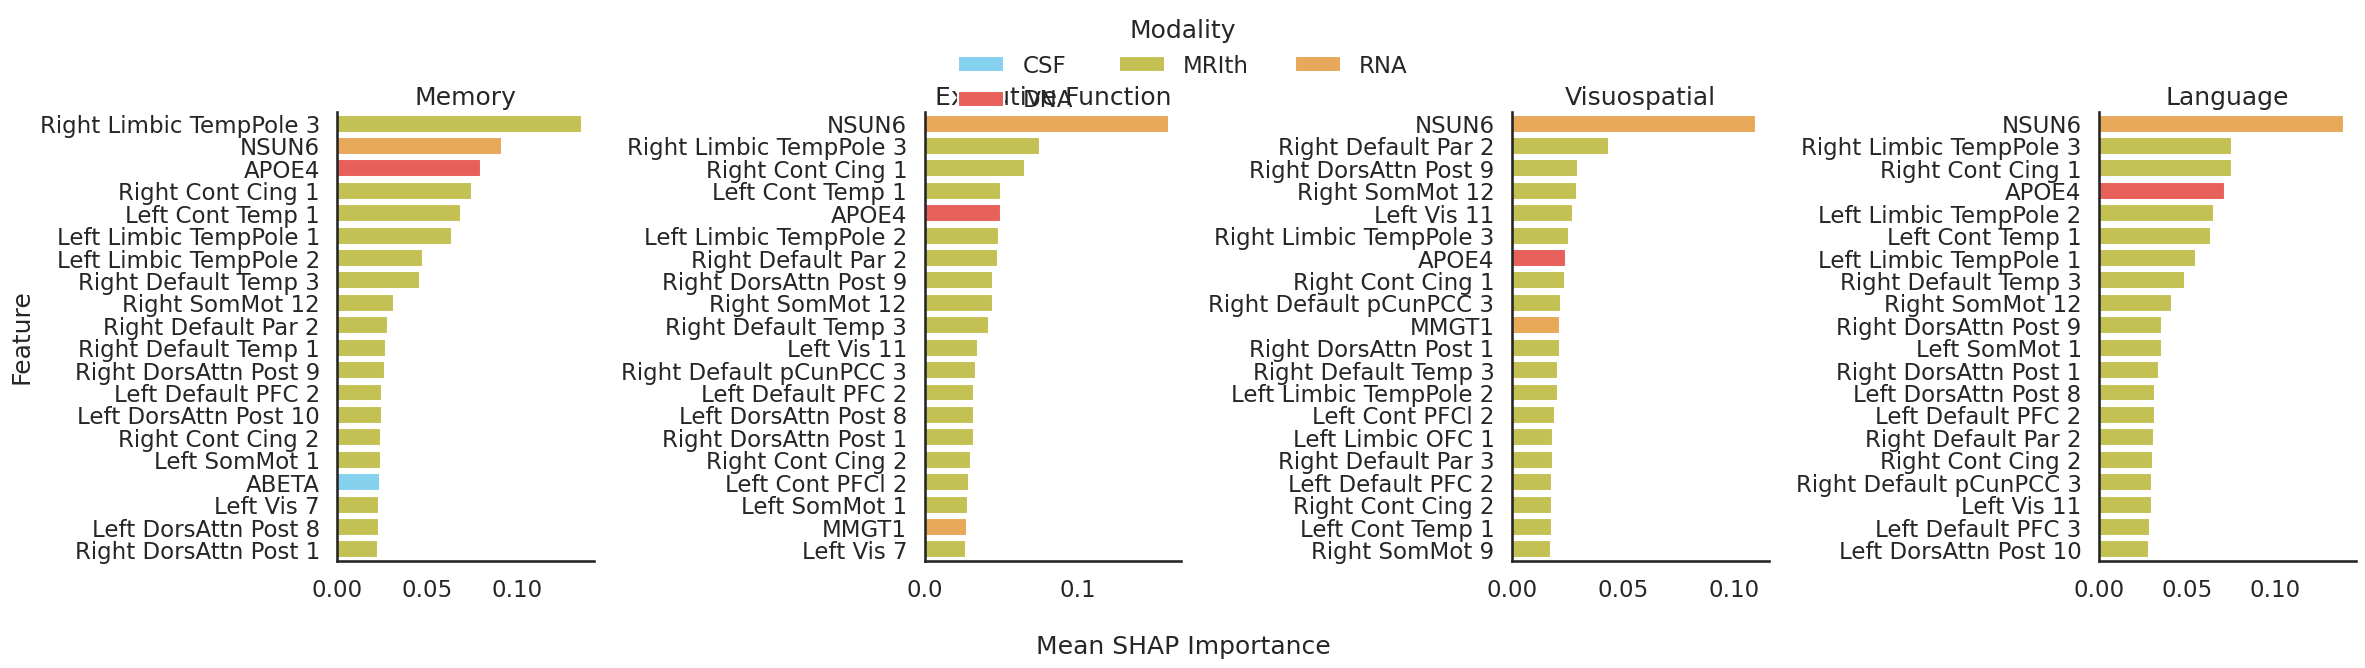

In [ ]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 6), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(shap_results.keys(), axes)):
    # Select the top n features for the current target
    importances = shap_results[target].head(n_features)
    importances['Category'] = importances['Feature'].map(
        lambda feature: next((key for key, columns in select.items() if feature in columns), 'Unknown')
    )
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax,
        palette=category_palette, hue="Category", orient="h"
    )
    
    # Update the y-tick labels
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    new_labels = [clean_ytick_label(label) for label in ytick_labels]
    ax.set_yticklabels(new_labels)
    
    # Title and labels
    readable_title = readable_names.get(target, target)  # Use readable name or fallback to original
    ax.set_title(readable_title, fontsize=18)
    
    ax.set_xlabel("")  # Remove individual x-labels
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature")
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y')

    ax.legend().set_visible(False)

# Remove duplicate legends and create a single, consistent legend
handles, labels = axes[0].get_legend_handles_labels()
unique_handles_labels = list(zip(handles, labels))
handles, labels = zip(*sorted(unique_handles_labels, key=lambda x: x[1]))  # Sort legend alphabetically

fig.legend(
    handles, labels, title="Modality", loc="upper center", bbox_to_anchor=(0.5, 1.1),
    ncol=3, frameon=False
)

# Add a single x-label in the bottom-middle of the figure
fig.text(0.5, 0.02, "Mean SHAP Importance", ha="center", va="center", fontsize=18)

sns.despine()

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the x-label
plt.show()


['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

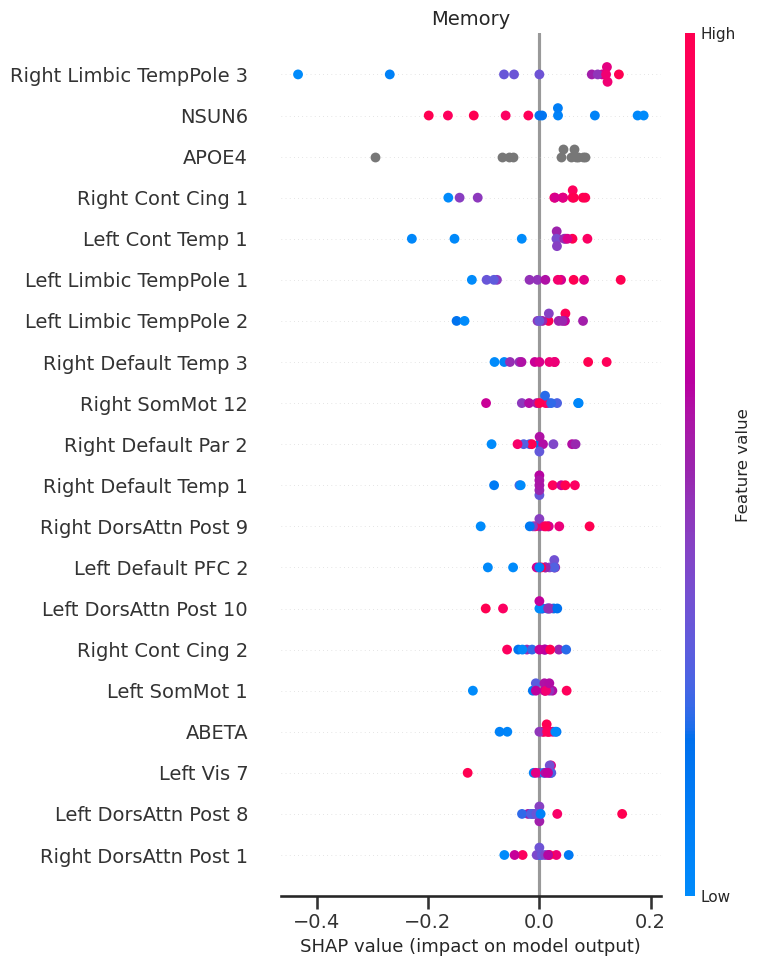

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

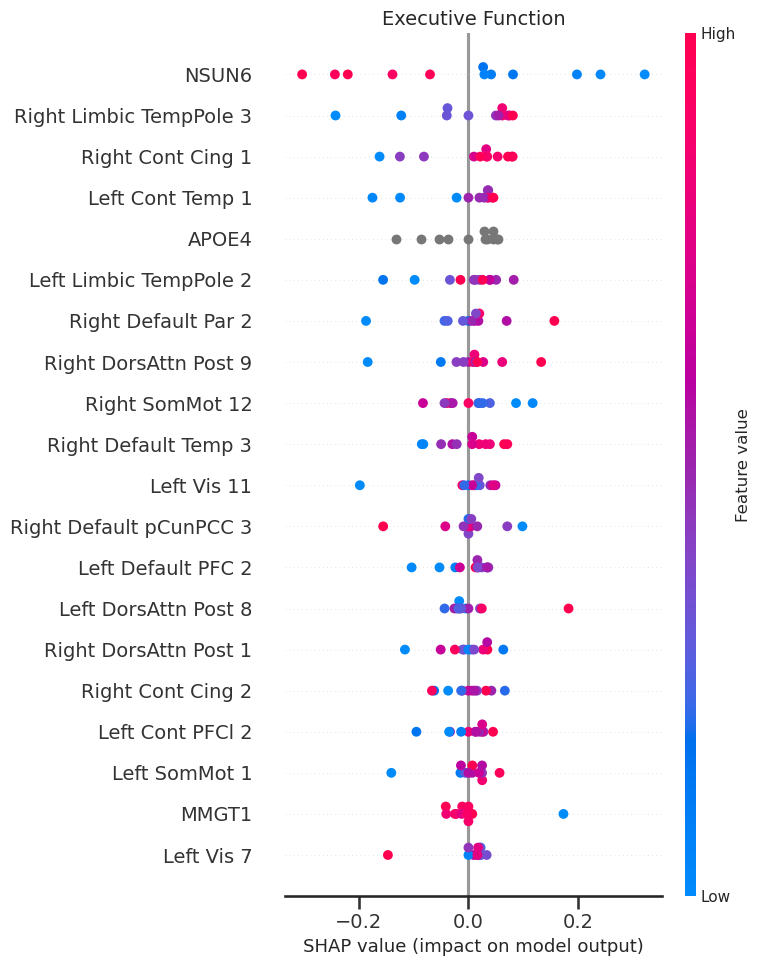

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

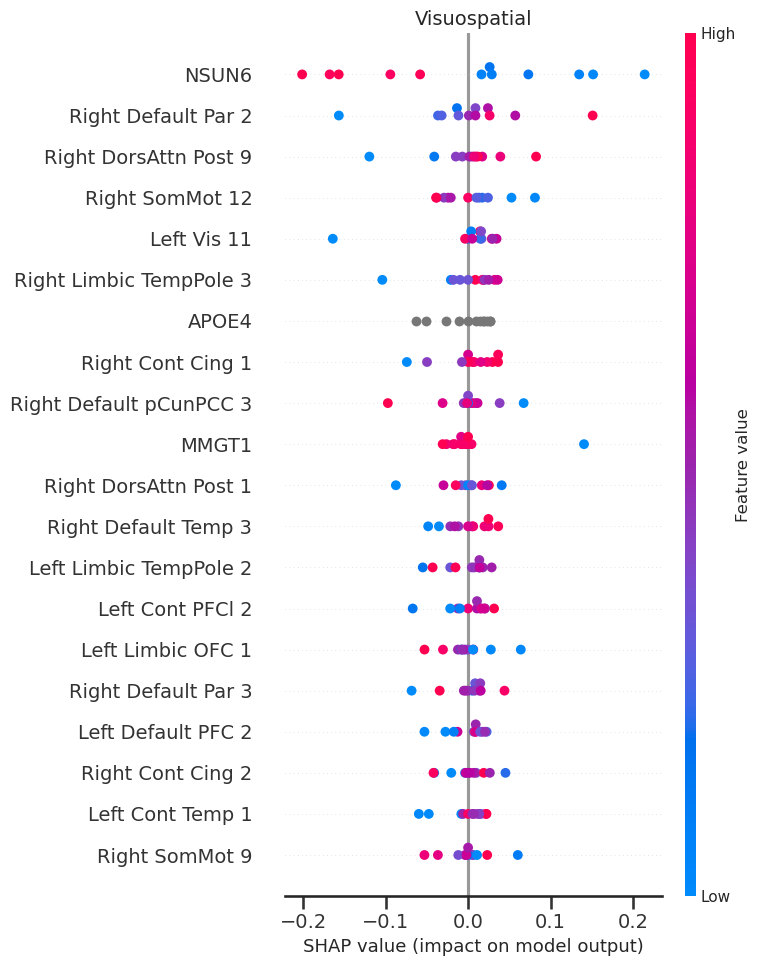

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

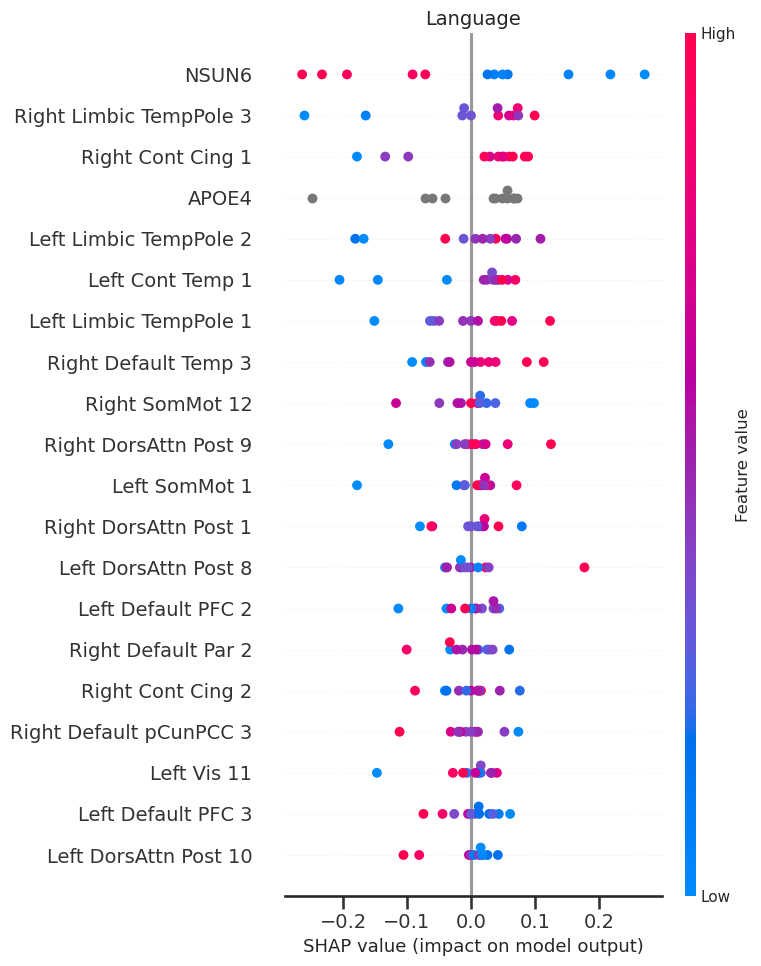

In [ ]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Clean feature names for readability
def clean_feature_names(features):
    return [clean_ytick_label(feature) for feature in features]

# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    # Get the readable target name
    readable_title = readable_names.get(target, target)  # Default to the original name if not found

    # Clean feature names
    clean_names = clean_feature_names(X_test.columns)
    print(f"{clean_names}")
    
    # Generate SHAP summary plot
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_test,
        feature_names=clean_names,  # Use cleaned feature names
        max_display=n_features,
        show=False  # Do not show the plot immediately
    )
    
    # Access the current figure and axes
    fig = plt.gcf()
    ax = plt.gca()
    
    # Adjust the figure size
    fig.set_size_inches(8, 10)  # Example size: 8x6 inches
    
    # Increase marker size
    for collection in ax.collections:
        if hasattr(collection, "set_sizes"):  # Check if it's a scatter plot
            collection.set_sizes([50])  # Set marker size (adjust as needed)
    
    # Set the readable title for the current target
    ax.set_title(readable_title, fontsize=14)  # Example: set the title size
    
    # Adjust tick label size
    ax.tick_params(axis="both", which="major", labelsize=14)  
    
    # Show the modified plot
    plt.tight_layout()
    plt.show()


##### Same but on X_train

In [ ]:
random_idx = random.sample(X_train_adjusted.index.tolist(), k=100)

X_test = X_train_adjusted.loc[random_idx]
Y_test = y_train_adjusted.loc[random_idx]

# Step 1: Initialize the SHAP Explainer and Compute SHAP Values
explainer = shap.KernelExplainer(model.model.predict, X_test)
shap_values = explainer(X_test)  # SHAP values for all targets

# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

  0%|          | 0/100 [00:00<?, ?it/s]

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

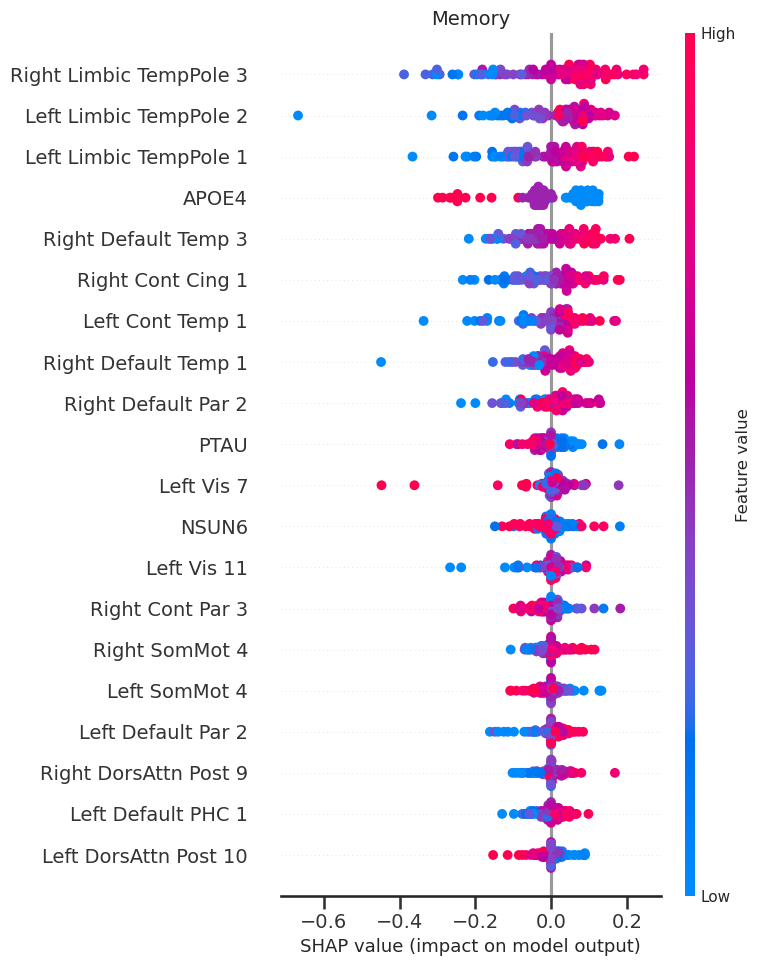

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

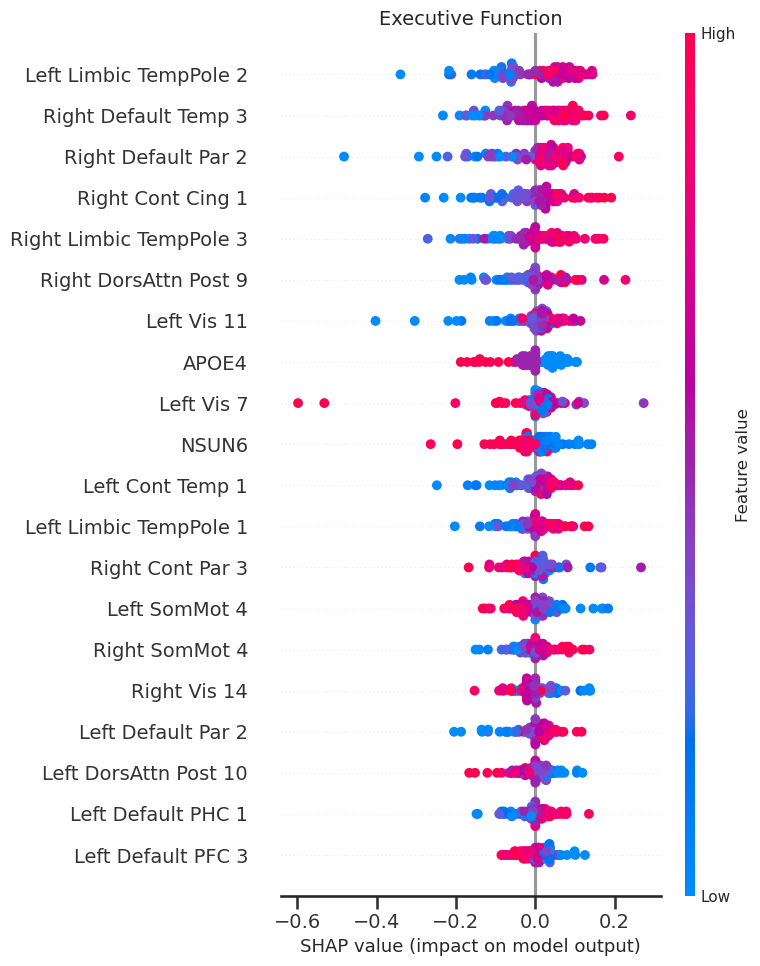

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

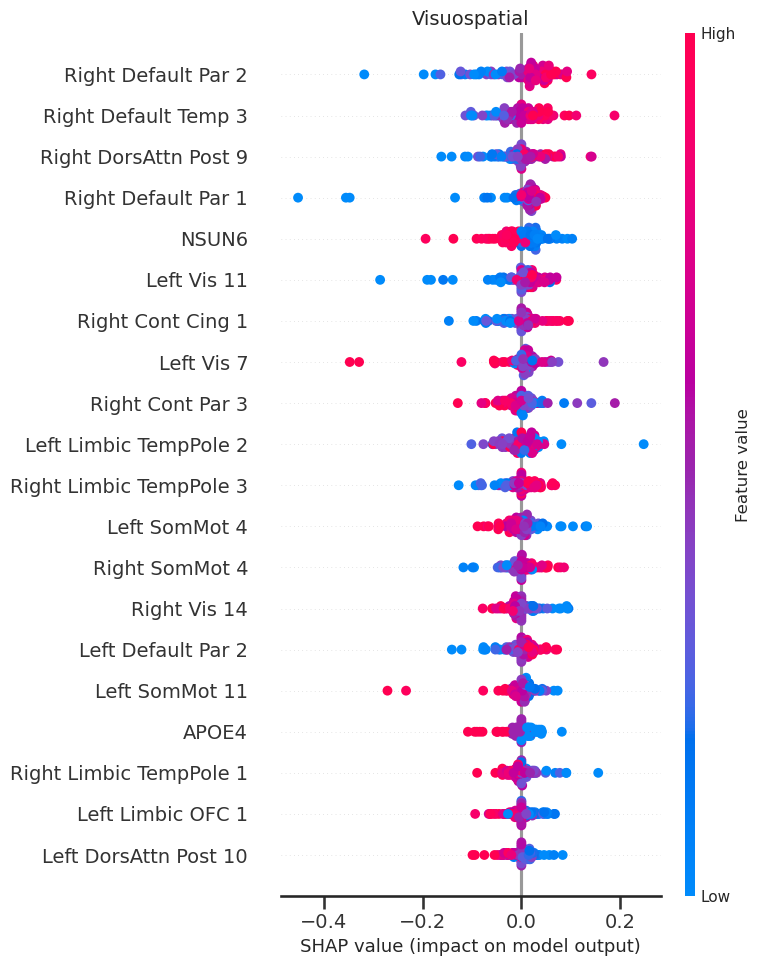

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

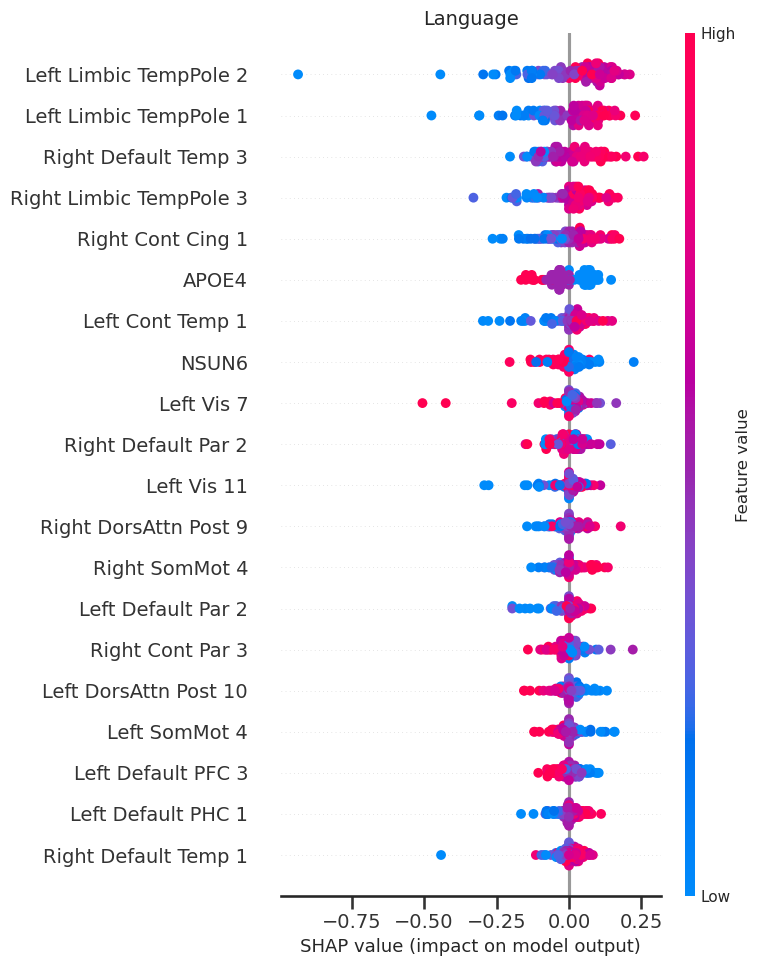

In [ ]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Clean feature names for readability
def clean_feature_names(features):
    return [clean_ytick_label(feature) for feature in features]

# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    # Get the readable target name
    readable_title = readable_names.get(target, target)  # Default to the original name if not found

    # Clean feature names
    clean_names = clean_feature_names(X_test.columns)
    print(f"{clean_names}")
    
    # Generate SHAP summary plot
    shap.summary_plot(
        shap_values.values[:, :, i],
        X_test,
        feature_names=clean_names,  # Use cleaned feature names
        max_display=n_features,
        show=False  # Do not show the plot immediately
    )
    
    # Access the current figure and axes
    fig = plt.gcf()
    ax = plt.gca()
    
    # Adjust the figure size
    fig.set_size_inches(8, 10)  # Example size: 8x6 inches
    
    # Increase marker size
    for collection in ax.collections:
        if hasattr(collection, "set_sizes"):  # Check if it's a scatter plot
            collection.set_sizes([50])  # Set marker size (adjust as needed)
    
    # Set the readable title for the current target
    ax.set_title(readable_title, fontsize=14)  # Example: set the title size
    
    # Adjust tick label size
    ax.tick_params(axis="both", which="major", labelsize=14)  
    
    # Show the modified plot
    plt.tight_layout()
    plt.show()


#### Save to csv for MATLAB

In [ ]:
permutation_results["ADNI_MEM"].head(20)

Feature  Importance
15                                  NSUN6    0.077681
227             LH_Default_PFC_2_Cortical    0.072053
108                  RH_SomMot_9_Cortical    0.058454
226             RH_Default_Par_2_Cortical    0.058410
73                      LH_Vis_7_Cortical    0.053045
135           LH_DorsAttn_Post_8_Cortical    0.047927
146           RH_DorsAttn_Post_9_Cortical    0.043349
129           LH_DorsAttn_Post_5_Cortical    0.042969
203               LH_Cont_Cing_1_Cortical    0.042614
76                      RH_Vis_8_Cortical    0.042472
23                                  YWHAZ    0.041945
254        RH_Default_PFCdPFCm_7_Cortical    0.038363
190                RH_Cont_Par_1_Cortical    0.038114
211            LH_Default_Temp_3_Cortical    0.035927
154           RH_DorsAttn_PrCv_1_Cortical    0.033600
196               RH_Cont_Temp_1_Cortical    0.033308
123           LH_DorsAttn_Post_2_Cortical    0.032774
188         RH_Limbic_TempPole_3_Cortical    0.032531
175         LH_Limbic_TempPole_2_Cortical    0.031565
156  RH_SalVentAttn_TempOccPar_1_Cortical    0.031141

In [ ]:
def extract_features_to_matrix(permutation_results, select_key, select_features):
    """
    Extract specific features from DataFrames in a dictionary and stitch them into a matrix.
    
    Args:
    - permutation_results (dict): Dictionary with keys (e.g., ['ADNI_MEM', 'ADNI_EF', ...])
                                  and values as DataFrames with 'Feature' and 'Importance' columns.
    - select_key (str): The key in the `select` dictionary to extract features from.
    - select_features (pd.Index or list): List or Index of features to extract.

    Returns:
    - pd.DataFrame: A matrix (DataFrame) where rows are features and columns are the keys from `permutation_results`.
    """
    # Initialize an empty dictionary to store extracted features
    extracted_data = {}
    
    for key, df in permutation_results.items():
        # Filter the DataFrame to include only the selected features in the specified order
        filtered_df = df[df['Feature'].isin(select_features)]
        # Reindex to ensure the features are in the same order as select_features
        reindexed_df = filtered_df.set_index('Feature').reindex(select_features)
        # Extract the Importance values
        extracted_data[key] = reindexed_df['Importance'].values
    
    # Combine the extracted Importance values into a single DataFrame
    combined_matrix = pd.DataFrame(extracted_data, index=select_features)
    
    return combined_matrix

In [ ]:
permutation_matrix = extract_features_to_matrix(permutation_results, 'MRIth', select["MRIth"])
permutation_matrix.to_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_permutation_mae_MRI.csv', index=False, header=False)

In [ ]:
shap_results.keys()

dict_keys(['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN'])

In [ ]:
shap_matrix = extract_features_to_matrix(shap_results, 'MRIth', select["MRIth"])
shap_matrix.to_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_shap_train_MRI.csv', index=False, header=False)

In [ ]:
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

def compute_agreement(matrix1, matrix2, top_k=20):
    # Ensure inputs are numpy arrays
    matrix1, matrix2 = np.array(matrix1), np.array(matrix2)
    
    # Rank correlation (average across columns)
    rank_correlation = np.mean([
        spearmanr(matrix1[:, i], matrix2[:, i]).correlation for i in range(matrix1.shape[1])
    ])
    
    # Cosine similarity (average across rows)
    row_cosine_similarity = np.mean(cosine_similarity(matrix1, matrix2))
    
    # Top-k feature overlap (Jaccard index)
    top_features1 = set(np.argsort(matrix1.mean(axis=1))[-top_k:])
    top_features2 = set(np.argsort(matrix2.mean(axis=1))[-top_k:])
    top_overlap = len(top_features1 & top_features2) / len(top_features1 | top_features2)
    
    # Element-wise agreement (MSE)
    mse_error = mean_squared_error(matrix1, matrix2)
    
    # Composite metric
    alpha1, alpha2, alpha3, alpha4 = 1, 1, 1, 1
    agreement_score = (
        alpha1 * rank_correlation +
        alpha2 * row_cosine_similarity +
        alpha3 * top_overlap -
        alpha4 * mse_error
    )
    
    return {
        "RankCorrelation": rank_correlation,
        "CosineSimilarity": row_cosine_similarity,
        "TopFeatureOverlap": top_overlap,
        "MSE": mse_error,
        "AgreementScore": agreement_score
    }

# Example Usage
# Assuming `perm_matrix` and `shap_matrix` are your two matrices
agreement_metrics = compute_agreement(permutation_matrix, shap_matrix)
print(agreement_metrics)


{'RankCorrelation': 0.40088952223805596, 'CosineSimilarity': 0.5009251462850364, 'TopFeatureOverlap': 0.48148148148148145, 'MSE': 0.00015449723848711238, 'AgreementScore': 1.3831416527660867}


In [ ]:
agree_matrix = permutation_matrix * shap_matrix
agree_matrix.to_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_agree_MRI.csv', index=False, header=False)

In [ ]:
local_importance = tabnet_model.model.feature_importances_
local_importance = local_importance[df_X.columns.isin(select["MRIth"])]

In [ ]:
pd.DataFrame(local_importance).to_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_local_MRI.csv', index=False, header=False)

#### Owen values

In [ ]:
model = tabnet_model

X_test = X_test_adjusted
Y_test = y_test_adjusted

# build a clustering of the features based on shared information about y
Y_train = y_train_adjusted
clustering = shap.utils.hclust(X_test)

# above we implicitly used shap.maskers.Independent by passing a raw dataframe as the masker
# now we explicitly use a Partition masker that uses the clustering we just computed
masker = shap.maskers.Partition(X_test, clustering=clustering)

# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.PartitionExplainer(model.model.predict, X_test)
shap_values2 = explainer(X_test)

PartitionExplainer explainer: 13it [00:11,  5.80s/it]                


['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

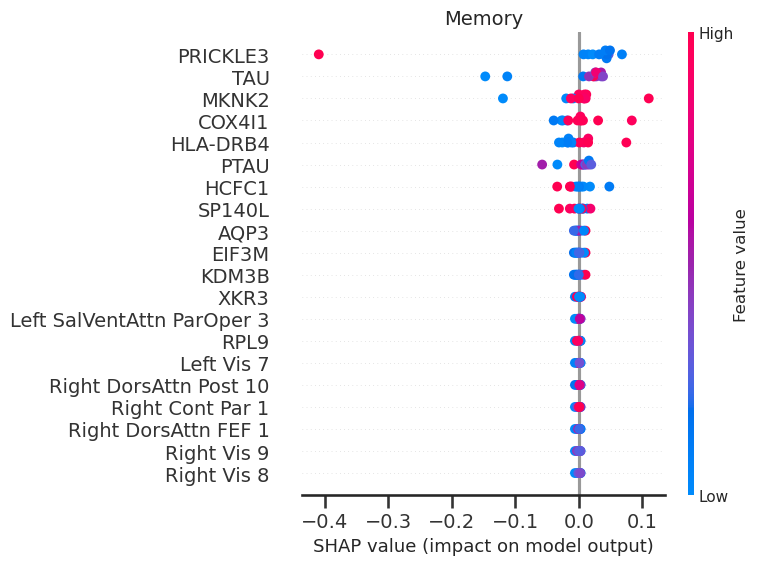

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

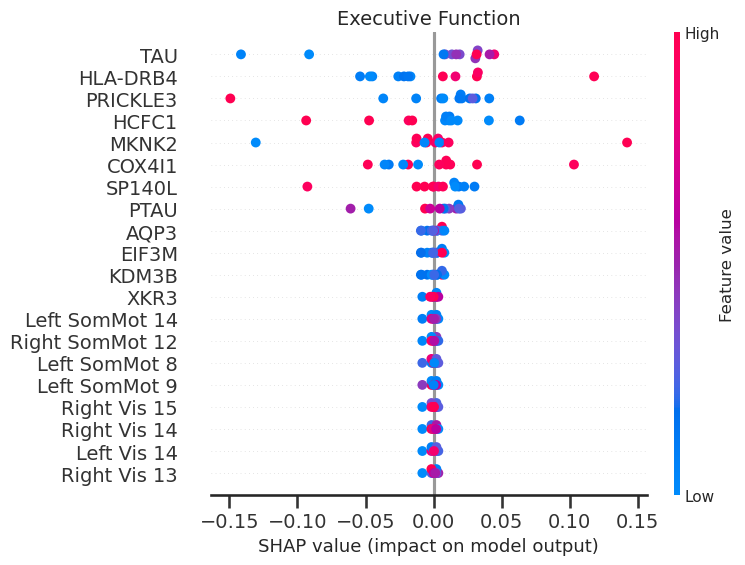

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

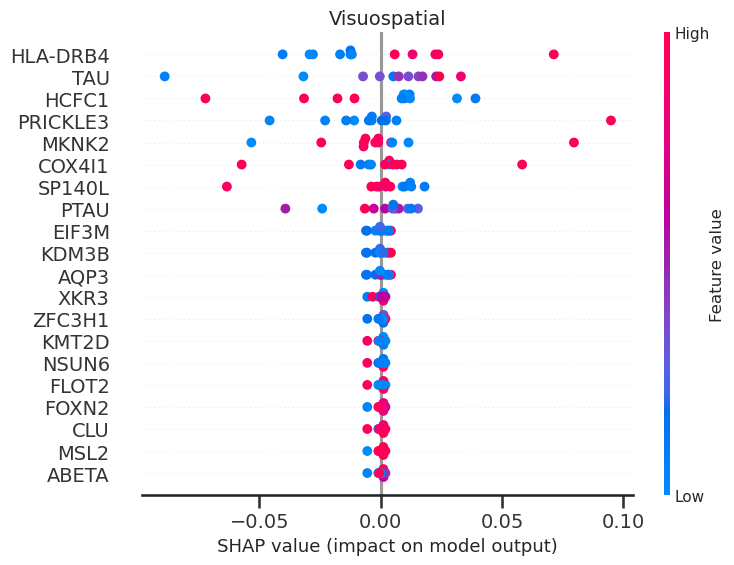

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

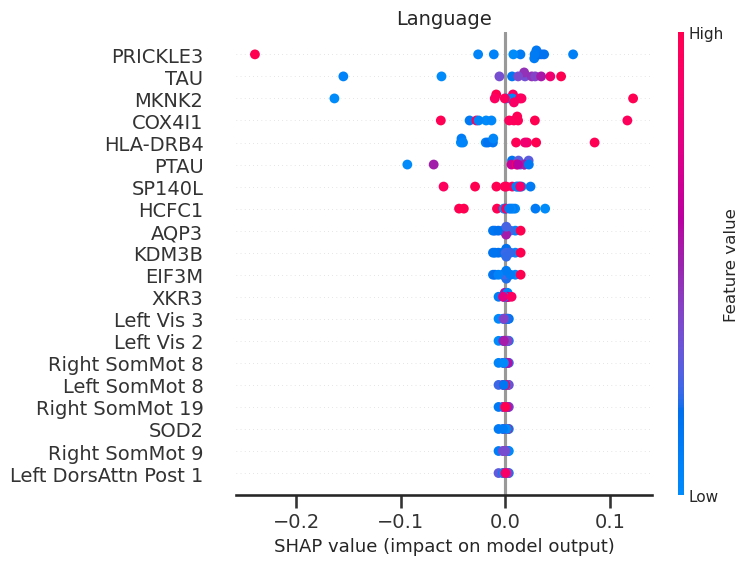

In [ ]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Clean feature names for readability
def clean_feature_names(features):
    return [clean_ytick_label(feature) for feature in features]

# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    # Get the readable target name
    readable_title = readable_names.get(target, target)  # Default to the original name if not found

    # Clean feature names
    clean_names = clean_feature_names(X_test.columns)
    print(f"{clean_names}")
    
    # Generate SHAP summary plot
    shap.summary_plot(
        shap_values2.values[:, :, i],
        X_test,
        feature_names=clean_names,  # Use cleaned feature names
        max_display=n_features,
        show=False  # Do not show the plot immediately
    )
    
    # Access the current figure and axes
    fig = plt.gcf()
    ax = plt.gca()
    
    # Adjust the figure size
    fig.set_size_inches(8, 6)  # Example size: 8x6 inches
    
    # Increase marker size
    for collection in ax.collections:
        if hasattr(collection, "set_sizes"):  # Check if it's a scatter plot
            collection.set_sizes([50])  # Set marker size (adjust as needed)
    
    # Set the readable title for the current target
    ax.set_title(readable_title, fontsize=14)  # Example: set the title size
    
    # Adjust tick label size
    ax.tick_params(axis="both", which="major", labelsize=14)  
    
    # Show the modified plot
    plt.tight_layout()
    plt.show()


#### Owen values on X_train subset

In [ ]:
model = tabnet_model

random_idx = random.sample(X_train_adjusted.index.tolist(), k=200)

X_test = X_train_adjusted.loc[random_idx]
Y_test = y_train_adjusted.loc[random_idx]

# build a clustering of the features based on shared information about y
Y_train = y_train_adjusted
clustering = shap.utils.hclust(X_test)

# above we implicitly used shap.maskers.Independent by passing a raw dataframe as the masker
# now we explicitly use a Partition masker that uses the clustering we just computed
masker = shap.maskers.Partition(X_test, clustering=clustering)

# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.PartitionExplainer(model.model.predict, X_test)
shap_values2 = explainer(X_test)

PartitionExplainer explainer: 201it [06:04,  1.87s/it]                         


In [ ]:
# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values2.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

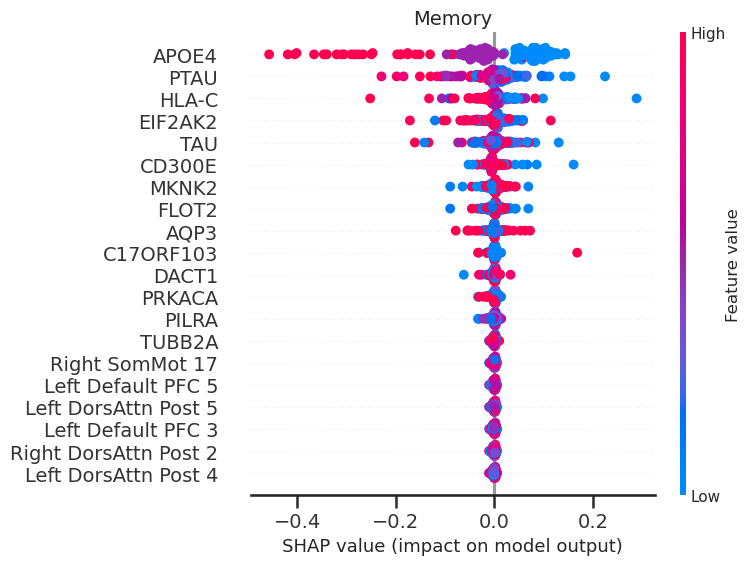

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

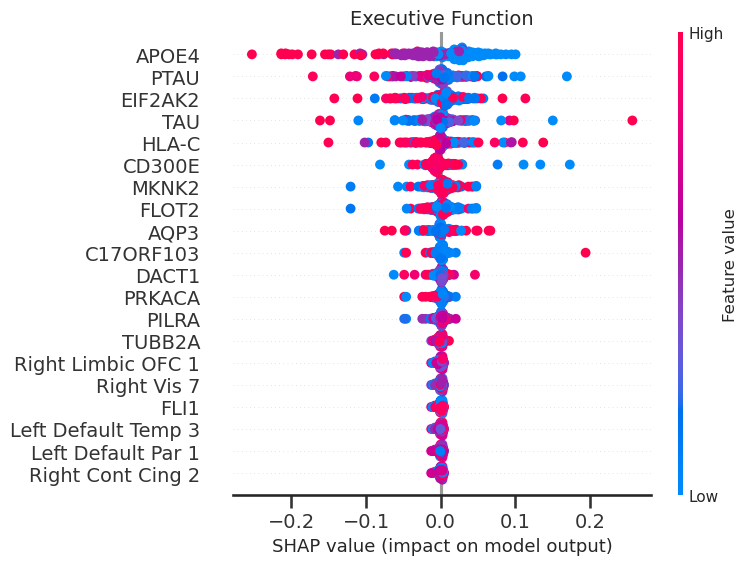

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

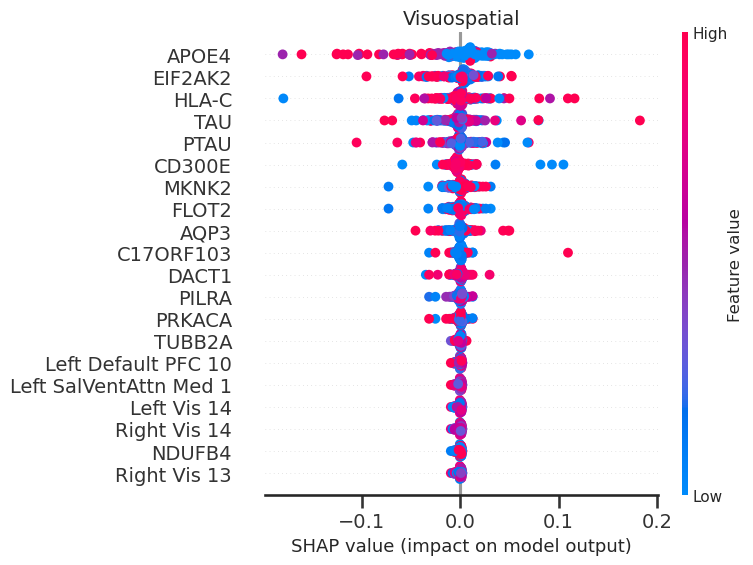

['ARG1', 'ZFAND6', 'C17ORF103', 'C6ORF25', 'CLU', 'CORO2B', 'CTNNB1', 'DACT1', 'ELOVL5', 'FOLR3', 'HCFC1', 'XKR3', 'MEAF6', 'MMGT1', 'NCOA5', 'NSUN6', 'PRICKLE3', 'RCC2', 'SELT*', 'TGFBR2', 'TNFRSF10B', 'TUBB2A', 'UBR2', 'YWHAZ', 'CCND3', 'EIF2AK2', 'EIF3M', 'HLA-DRB4', 'NDUFB4', 'SOD2', 'SP140L', 'AQP3', 'ARID1B', 'ATP5F1', 'CD300E', 'COX4I1', 'EIF1AD', 'FLI1', 'FLOT2', 'FOXN2', 'HLA-C', 'HMGB2', 'KDM3B', 'KMT2D', 'MAT2B', 'MKNK2', 'MSL2', 'MYLIP', 'ORM1', 'OXSR1', 'PILRA', 'PRKACA', 'RPL9', 'TMED2', 'ZFC3H1', 'ABETA', 'TAU', 'PTAU', 'APOE2', 'APOE3', 'APOE4', 'Left Vis 1', 'Right Vis 1', 'Left Vis 2', 'Right Vis 2', 'Left Vis 3', 'Right Vis 3', 'Left Vis 4', 'Right Vis 4', 'Left Vis 5', 'Right Vis 5', 'Left Vis 6', 'Right Vis 6', 'Left Vis 7', 'Right Vis 7', 'Left Vis 8', 'Right Vis 8', 'Left Vis 9', 'Right Vis 9', 'Left Vis 10', 'Right Vis 10', 'Left Vis 11', 'Right Vis 11', 'Left Vis 12', 'Right Vis 12', 'Left Vis 13', 'Right Vis 13', 'Left Vis 14', 'Right Vis 14', 'Left SomMot 1',

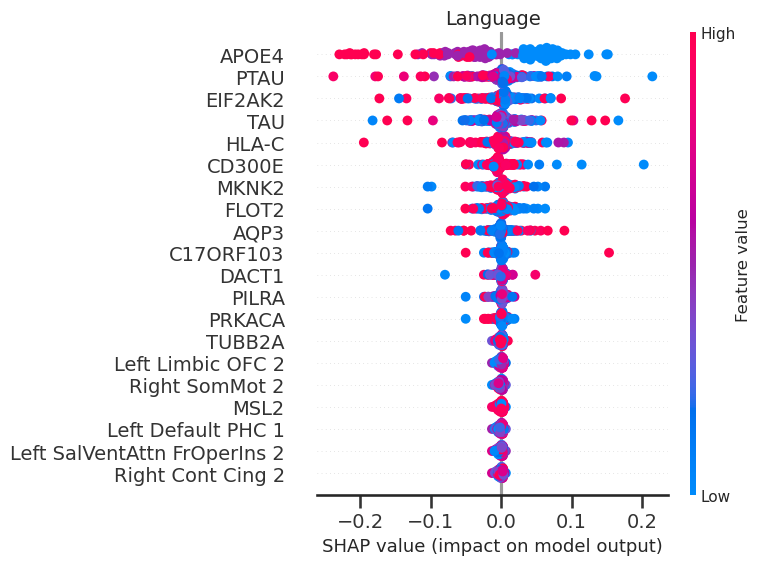

In [ ]:
# Seaborn style settings
sns.set_style("white")
sns.set_context("talk")

# Dictionary to map original target names to readable names
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
    # Add other target mappings as needed
}

# Clean feature names for readability
def clean_feature_names(features):
    return [clean_ytick_label(feature) for feature in features]

# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    # Get the readable target name
    readable_title = readable_names.get(target, target)  # Default to the original name if not found

    # Clean feature names
    clean_names = clean_feature_names(X_test.columns)
    print(f"{clean_names}")
    
    # Generate SHAP summary plot
    shap.summary_plot(
        shap_values2.values[:, :, i],
        X_test,
        feature_names=clean_names,  # Use cleaned feature names
        max_display=n_features,
        show=False  # Do not show the plot immediately
    )
    
    # Access the current figure and axes
    fig = plt.gcf()
    ax = plt.gca()
    
    # Adjust the figure size
    fig.set_size_inches(8, 6)  # Example size: 8x6 inches
    
    # Increase marker size
    for collection in ax.collections:
        if hasattr(collection, "set_sizes"):  # Check if it's a scatter plot
            collection.set_sizes([50])  # Set marker size (adjust as needed)
    
    # Set the readable title for the current target
    ax.set_title(readable_title, fontsize=14)  # Example: set the title size
    
    # Adjust tick label size
    ax.tick_params(axis="both", which="major", labelsize=14)  
    
    # Show the modified plot
    plt.tight_layout()
    plt.show()


In [ ]:
owen_matrix = extract_features_to_matrix(shap_results, 'MRIth', select["MRIth"])
owen_matrix.to_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_owen_train_MRI.csv', index=False, header=False)

## Train PLS_Regressor_4_ components

In [ ]:
if True: 

    idx_train = list(df_X.isna().any(axis=1))
    idx_test = list(~df_X.isna().any(axis=1))

    set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
    intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

    for i, bool_test in enumerate(idx_test): 
        if intersect_rid_idx.iloc[i] & bool_test:
            idx_test[i] = False
            idx_train[i] = True

    df_X_train = df_X.loc[idx_train]
    df_X_test = df_X.loc[idx_test]

    df_y_train = df_y.loc[idx_train]
    df_y_test = df_y.loc[idx_test]

    c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
    c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

    continuous_model  = imputer = KNNImputer(n_neighbors=1)
    name_continuous_imputer  = "KNNImputer"
    ordinal_model = SimpleImputer(strategy="constant", fill_value=-1)
    name_ordinal_imputer = "SimpleImputer_constant"
    pls_model = PLSRegression(n_components=4)
    name_model = "PLSRegression_4_Components"

    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Separate imputers for ordinal and continuous data
    print("Using separate imputers for ordinal and continuous data.")

    df_X_train = df_X_train.copy()
    df_X_test = df_X_test.copy()

    # Continuous Imputation Transformer (Example: SimpleImputer)
    continuous_imputer = Pipeline([
        (name_continuous_imputer, continuous_model),
    ])

    # Ordinal Imputation Transformer (Example: KNN Imputer)
    ordinal_imputer = Pipeline([
        (name_ordinal_imputer, ordinal_model)
    ])

    # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_imputer, ordinal_features),
            ('continuous', continuous_imputer, continuous_features)
        ],
        remainder='passthrough'
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

        # Separate imputers for ordinal and continuous data

    # Fit and transform, then convert back to DataFrame with original column names
    start = time.time()
    pipeline.fit(df_X_train)
    end = time.time()

    impute_model_time = end - start

    X_train_imputed = pipeline.transform(df_X_train)
    df_X_train_imputed = df_X_train.copy()
    df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

    # Transform the test set
    if df_X_test.isna().any().any(): 
        X_test_imputed = pipeline.transform(df_X_test)
        df_X_test_imputed = df_X_test.copy()
        df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
    else : 
        print("No NaN in test data -> Keep as it is. ")
        df_X_test_imputed = df_X_test

    #df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("category")
    #df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("category")

    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()

    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

    # Perform prediction and save variables
    start = time.time()
    pls_model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = pls_model.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }

    def compute_all_metrics(y_test, y_pred): 
        # Metrics computed in adjusted space
        mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
        mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
        r2 = r2_score(y_test,y_pred, multioutput="raw_values")
        explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

        try: 
            corr_p = correlation(y_pred, y_test)
        except: 
            print("Problem when computing correlation!")
            if type(y_test) != type(y_pred): 
                print("Type of inputs is different.")
                corr_p = None
            else : 
                corr_p = pearsonr(y_test, y_pred)

        return mse_score, mae_score, r2, explained_variance, corr

    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }


Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
Problem when computing correlation!
Type of inputs is different.
Problem when computing correlation!
Type of inputs is different.


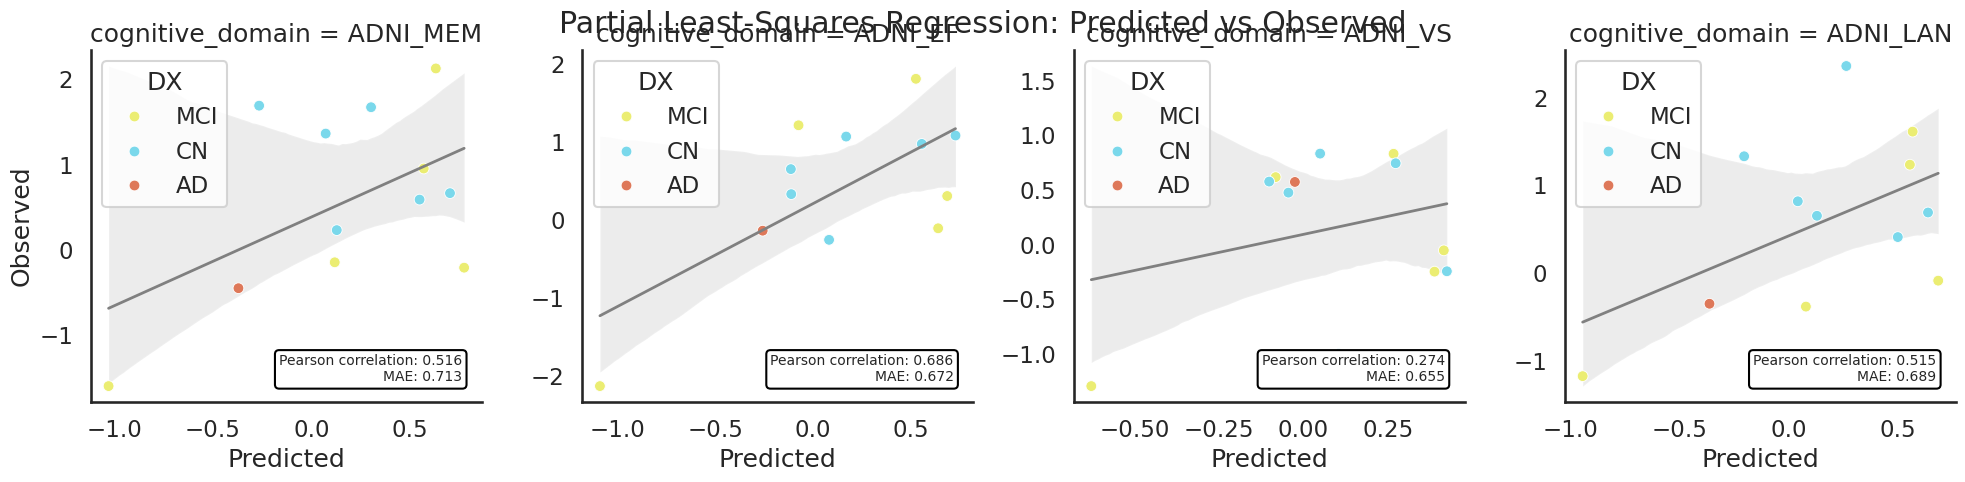

In [ ]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

# Create the lmplot with only the regression line
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # Remove scatter points
    line_kws={"color": "grey", "lw": 2}  # Customize regression line
)

# Extract the order of cognitive domains from the lmplot
cognitive_domains_order = g.col_names

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=60
    )
    
    # Calculate Pearson correlation and MAE
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])
    
    # Add text annotation in the lower right corner
    ax.text(
        0.95, 0.05,  # Position in axes coordinates
        f"Pearson correlation: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

# Adjust layout and title
g.set_axis_labels("Predicted", "Observed")
g.fig.subplots_adjust(top=0.9)  # Adjust the top for title space
g.fig.suptitle("Partial Least-Squares Regression: Predicted vs Observed")  # Add a title

plt.show()


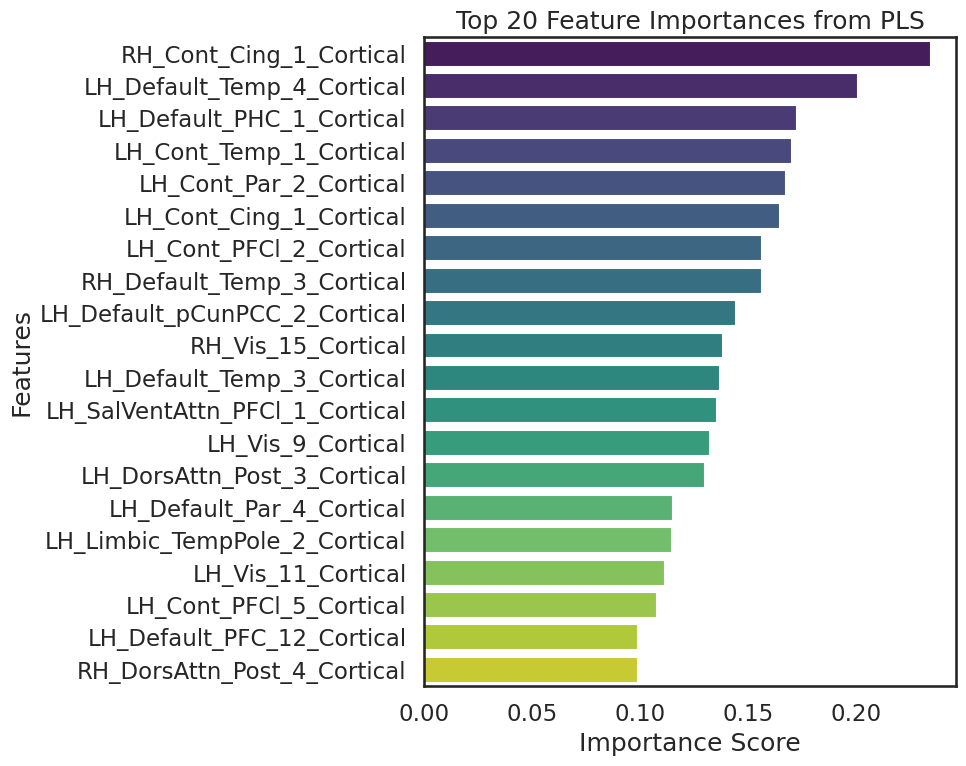

In [ ]:

# Example: Assuming your RandomForestRegressor is already trained
# rf_model = RandomForestRegressor(...)
# rf_model.fit(X_train, y_train)

# Extract feature importances
feature_importances = pls_model.coef_.mean(axis=0)

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top 20
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Plot the top 20 feature importances using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(data=top_features_df, x="Importance", y="Feature", palette="viridis")
plt.title(f"Top {n_features} Feature Importances from PLS")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

#### Permutation importance values

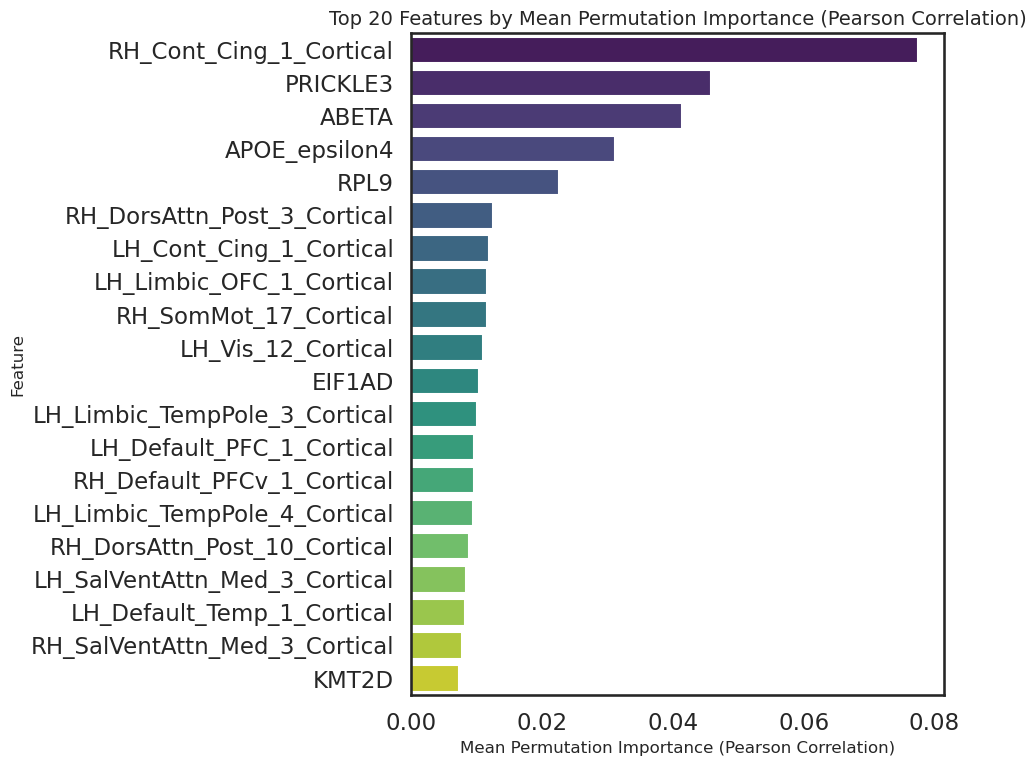

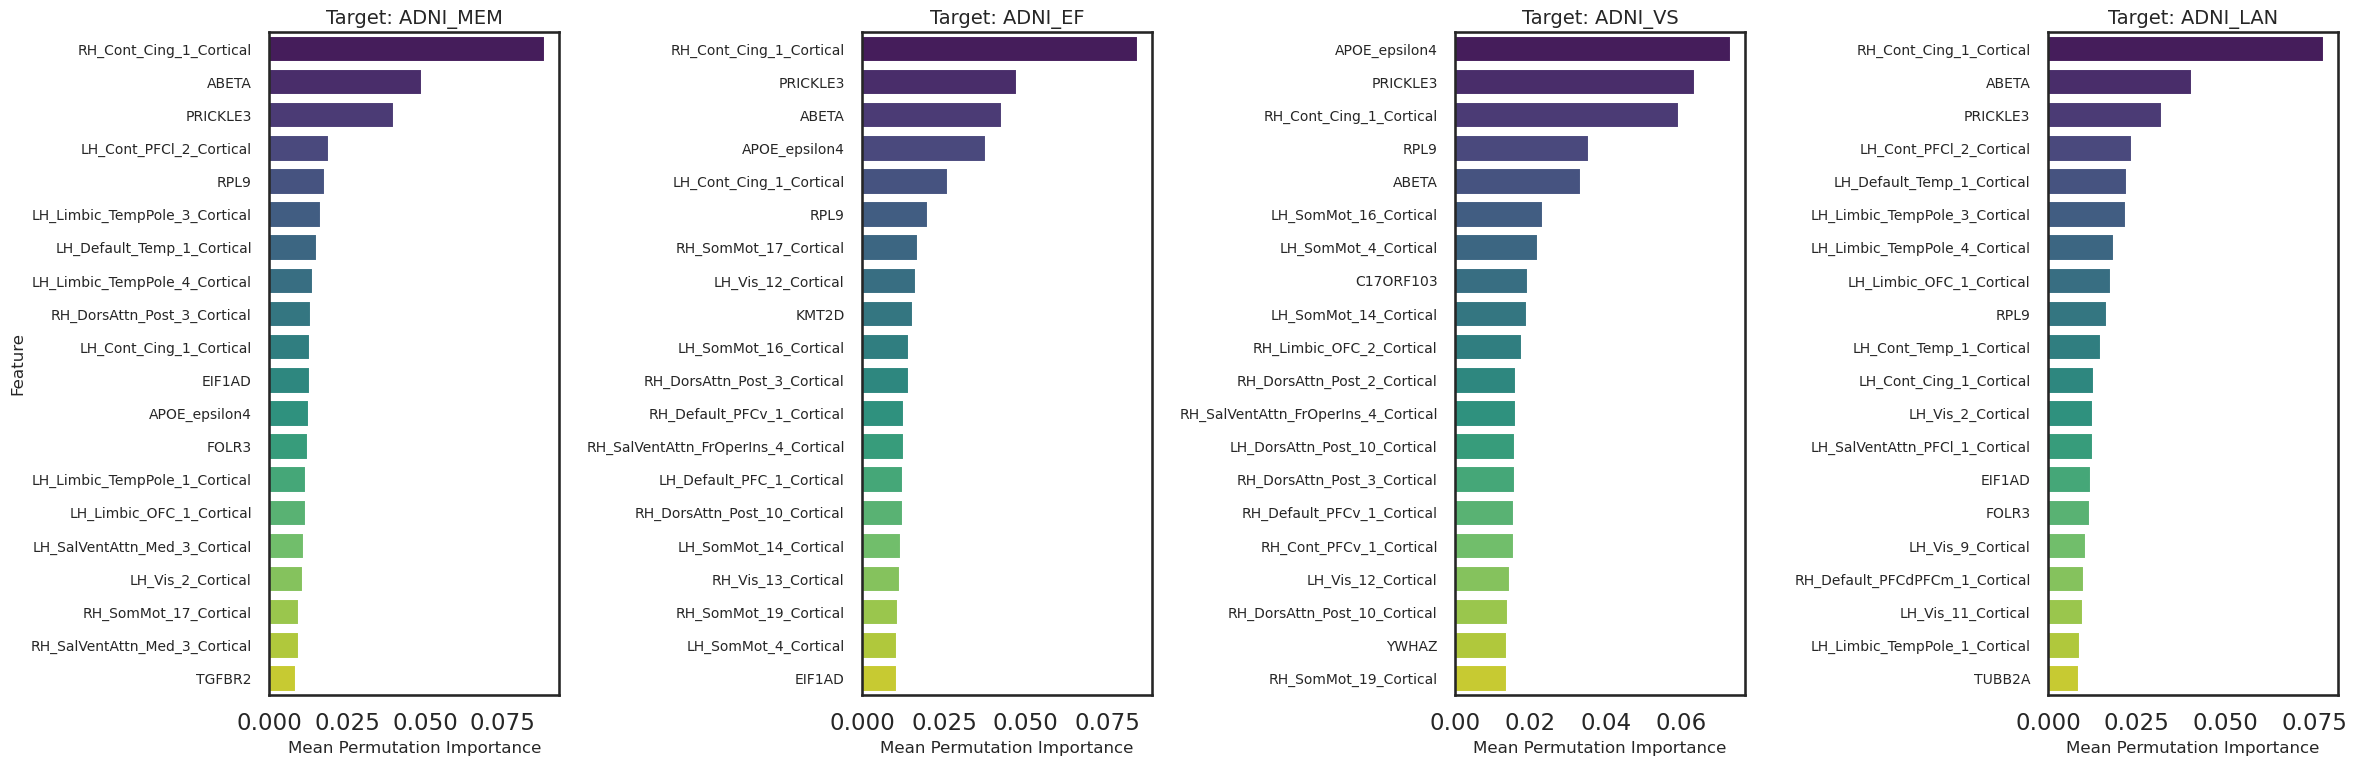

In [ ]:
X_test = X_test_adjusted
X_train = X_train_adjusted
Y_test = y_test_adjusted

model = pls_model

# Compute permutation importance with Pearson correlation as the scoring metric
result = permutation_importance(
    model, X_test, Y_test, scoring=pearson_scorer, n_repeats=10, random_state=42
)

# Step 1: Extract importance for each target
permutation_results = {}
for i, target in enumerate(Y_test.columns):
    permutation_results[target] = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean[:, i]  # Extract importance for this target
    }).sort_values(by="Importance", ascending=False)

# Step 2: Mean importance across targets
mean_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean.mean(axis=1)  # Mean importance across targets
}).sort_values(by="Importance", ascending=False)


# # Step 4: Plot for each target
# for target in permutation_results:
#     plot_importance(
#         permutation_results[target], title=f"Top 40 Features for Target: {target}"
#     )

# Step 5: Plot for top mean importances across all targets
plot_importance(mean_importance, title=f"Top {n_features} Features by Mean Permutation Importance (Pearson Correlation)", top_n=n_features)

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = permutation_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h",
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Permutation Importance", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

#### Shapeley values

  0%|          | 0/12 [00:00<?, ?it/s]

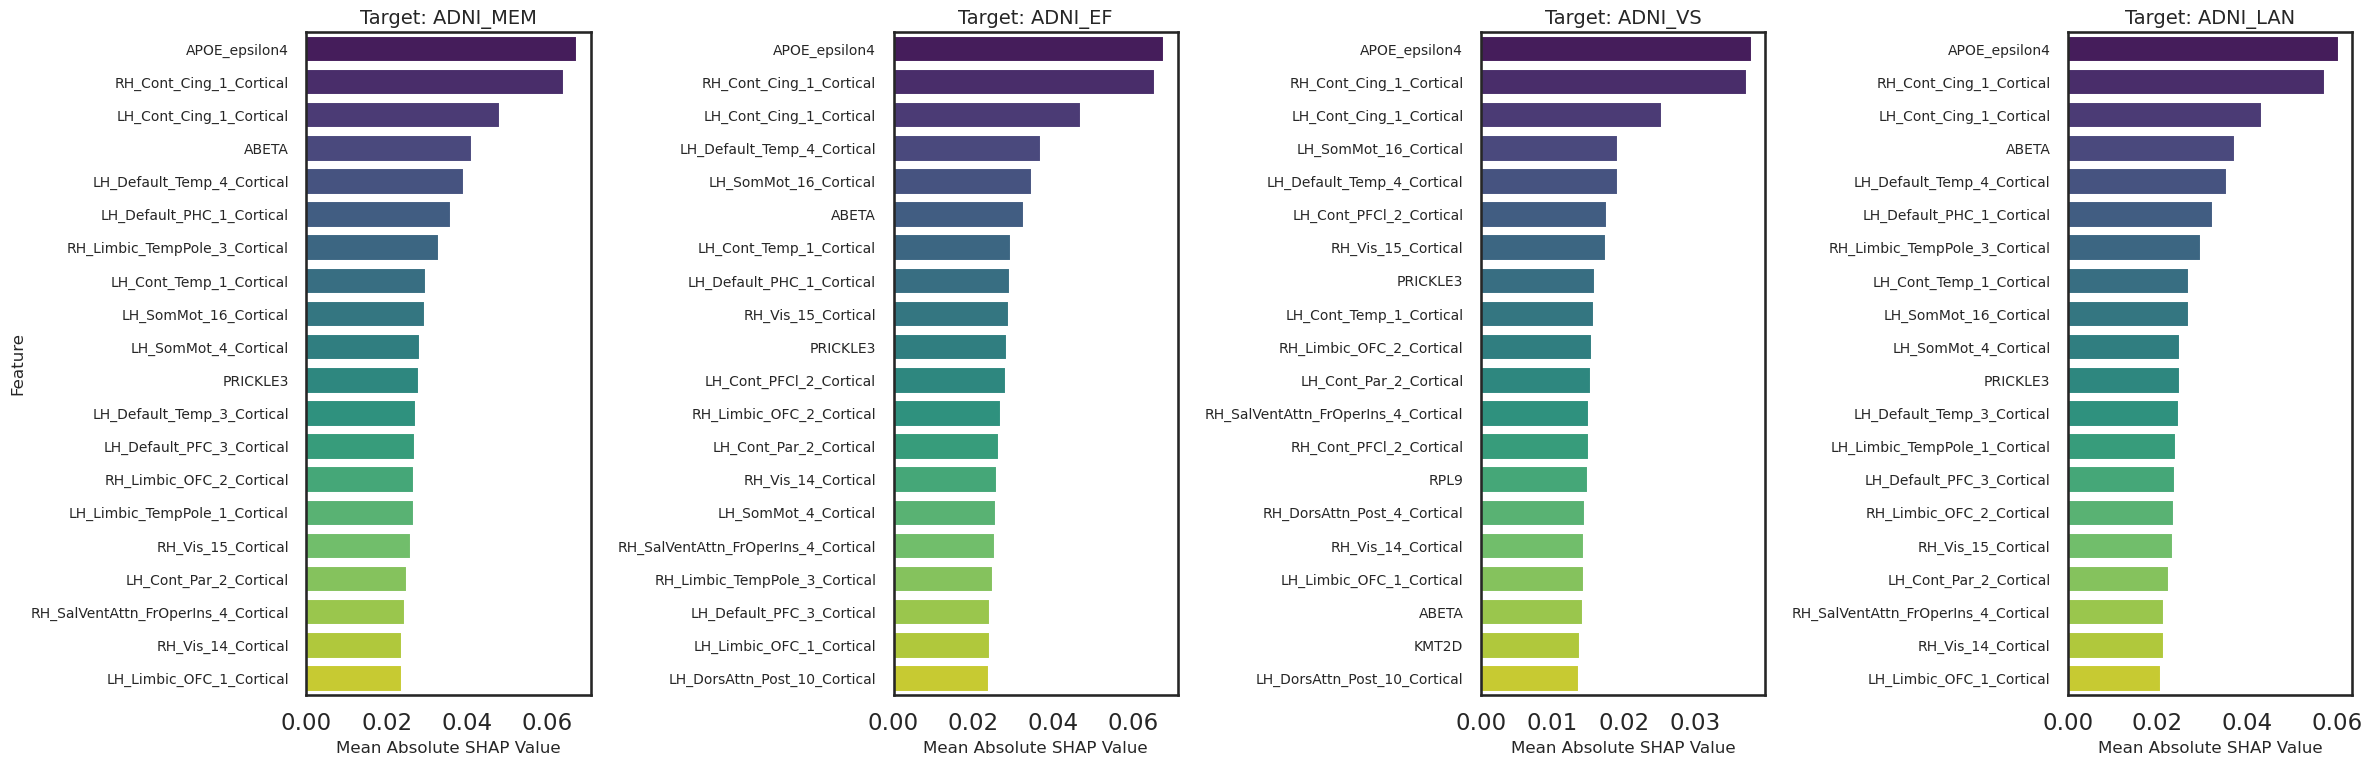

In [ ]:
# Step 1: Initialize the SHAP Explainer and Compute SHAP Values
explainer = shap.KernelExplainer(model.predict, X_test)
shap_values = explainer(X_test)  # SHAP values for all targets

# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

# Step 3: Plot top features for each target as subplots
num_targets = len(Y_test.columns)
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

for i, (target, ax) in enumerate(zip(shap_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = shap_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h"
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Absolute SHAP Value", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


SHAP Summary for Target: ADNI_MEM


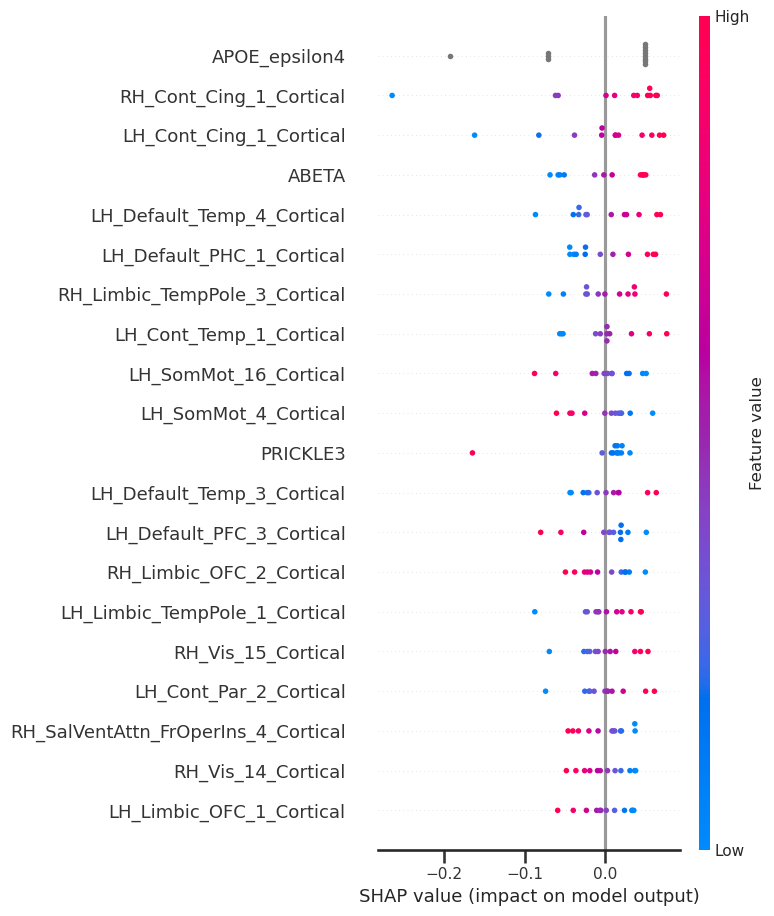

SHAP Summary for Target: ADNI_EF


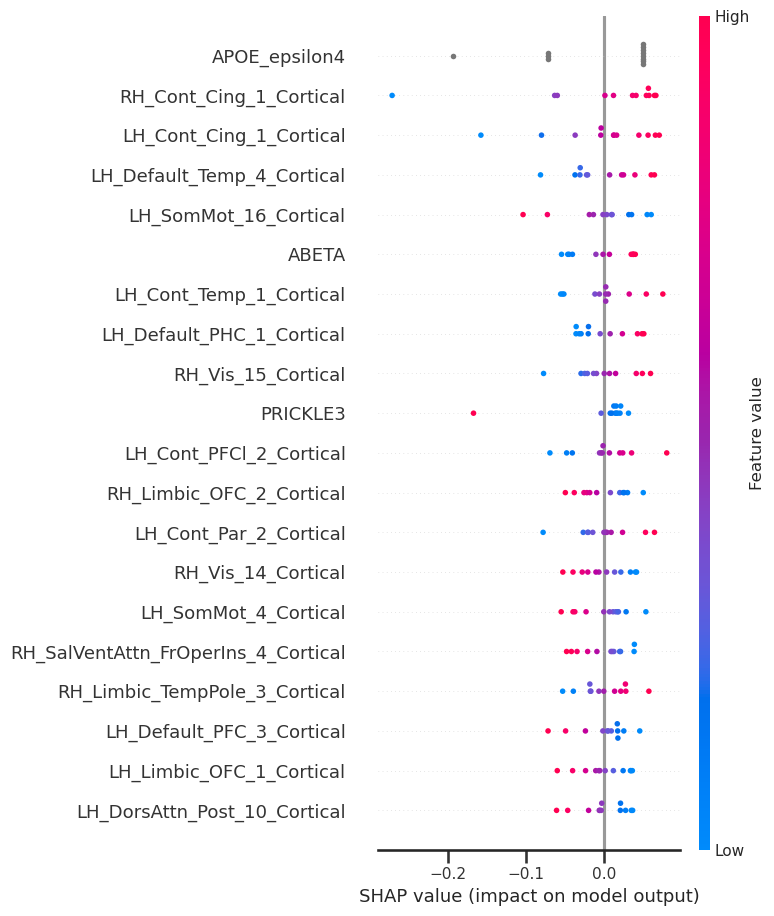

SHAP Summary for Target: ADNI_VS


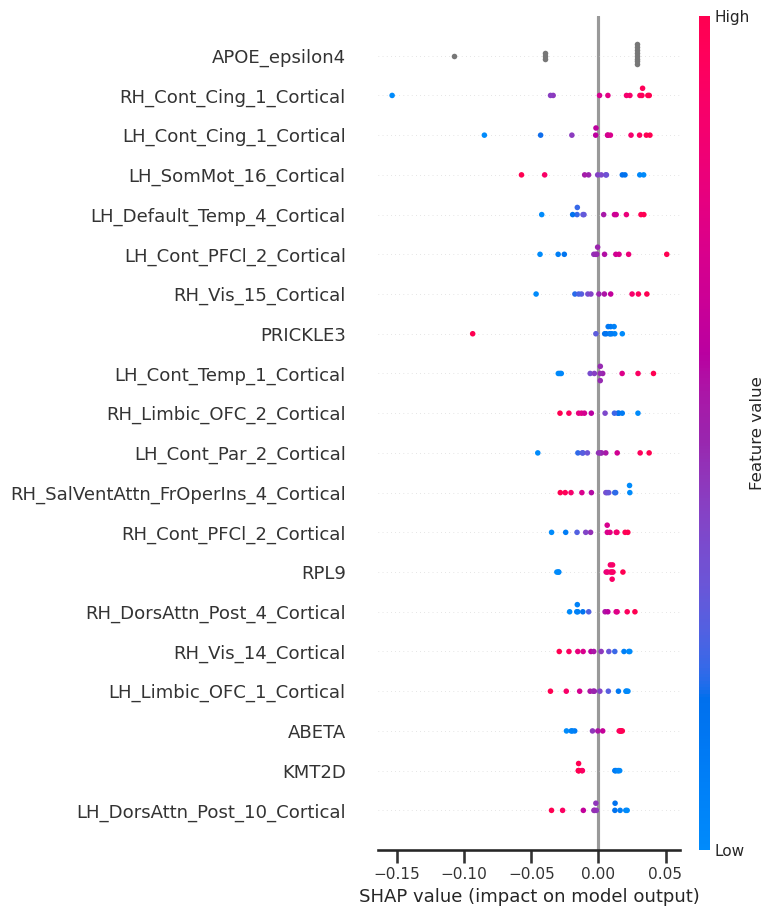

SHAP Summary for Target: ADNI_LAN


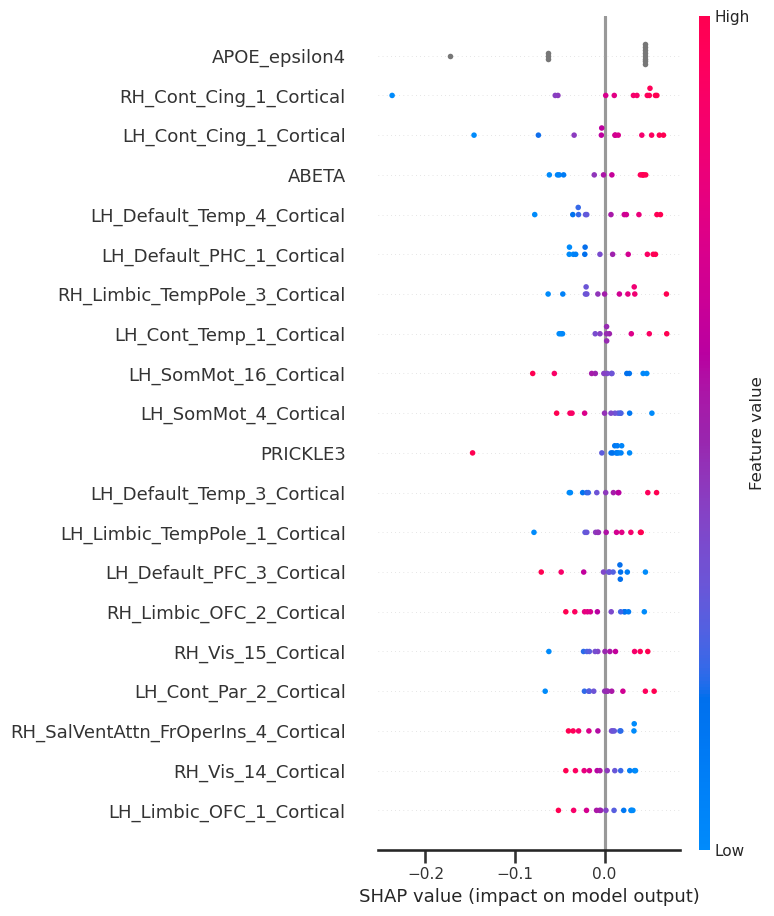

In [ ]:
# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    print(f"SHAP Summary for Target: {target}")
    shap.summary_plot(shap_values.values[:, :, i], X_test, feature_names=X_test.columns, max_display=n_features)